# ADA project final notebook
In this notebook we put everything we have for the final milestone. All we did for milestone 2 is contained in the [first part](#milestone_2) and what we did from the second to the third milestone is located in the [second part](#milestone_3)

<a id='milestone_2'></a>
# Milestone 2: Getting acquainted with the data

# Introduction
In this part we process all the data we need for our project. We take a very closed look at what is inside our data, more precisely the [Million Song Dataset](https://labrosa.ee.columbia.edu/millionsong/), the [MusixMatch](https://labrosa.ee.columbia.edu/millionsong/musixmatch) dataset and the [Taste Profile](https://labrosa.ee.columbia.edu/millionsong/tasteprofile) dataset.

In the first part of our part we measure the offensiveness of a song. We start by trying to find a dataset which gives the swear/offensive words we need for our analysis, we look at that dataset and try to figure out what to do with it. Once we have our swear words, we look at the lyrics of our songs (we do not have the lyrics for all the songs) and do some swear words counting to get the measure of offensiveness for a given song.

Then we try to look at the second measure we need beside offensiveness: the popularity of a song. We mainly have 2 different ways of doing that: one is to use a parameter in the metadata of the Million Song Dataset called the song "hotness", which means popularity. The second is by counting how many times a given song has been played by users looking at the Taste Profile dataset.

# 1. Measuring the offensiveness of a song

First things first, the most important thing we want to have for our project is a way to measure the offensiveness of a song. We will do this by counting the number of offensive words in a song. 

## Setting up a Dataframe for the rating of offensiveness
I'm using a paper released by the British telecommunications regulator Ofcom: https://www.ofcom.org.uk/__data/assets/pdf_file/0023/91625/OfcomQRG-AOC.pdf

There is a useful transcription here:
http://metro.co.uk/2016/10/02/swearing-ranked-from-mild-to-strongest-6165629/#

I created a JSON file from the data of that website.
This section will load this file and convert it to a Dataframe with a usable layout.

In [1]:
import json
import pandas as pd
import sqlite3
from tqdm import tqdm
import numpy as np
import h5py
import os
import glob
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
with open("../datasets/metro_co_uk_transcription.json") as file:
    offensiveness_rating = json.load(file)
    
# the offensiveness rating is a nested JSON file
# after three levels of json objects, there is a list of words
# it looks like this:
print(offensiveness_rating["discriminatory"]["religion"]["strong"])
print(offensiveness_rating["discriminatory"]["race"]["medium"])

# there are also offensive words that are not discriminating
# for them, the second key doesn't really make sense, I just entered "offensive"
print(offensiveness_rating["non-discriminatory"]["offensive"]["mild"])

['Fenian', 'Kafir', 'Kufaar', 'Kike', 'Papist', 'Prod', 'Taig', 'Yid']
['Kraut', 'Pikey', 'Taff']
['Arse', 'Bloody', 'Bugger', 'Cow', 'Crap', 'Damn', 'Ginger', 'Git', 'God', 'Goddam', 'Jesus Christ', 'Minger', 'Sod-off']


In [3]:
# for further processing, we want to have a dataframe with the words as index
# a cell in the dataframe should be a word and the rating of offensiveness
# if the word is discriminating, we also want to have the target group

entries = []

def clean(word):
    return word.strip().lower()

# words are always three levels down in the file
for category, value in offensiveness_rating.items():
    for target, value in value.items():
        for strength, words in value.items():
            for word in words:
                entry = {}
                entry["category"] = clean(category)
                entry["word"] = clean(word)
                entry["strength"] = clean(strength)
                
                assert category in ["discriminatory", "non-discriminatory"]
                
                if category=="discriminatory":
                    entry["target"] = clean(target)
                else:
                    entry["target"] = None
                
                entries.append(entry)

In [4]:
entries[:2]

[{'category': 'non-discriminatory',
  'strength': 'mild',
  'target': None,
  'word': 'bonk'},
 {'category': 'non-discriminatory',
  'strength': 'strong',
  'target': None,
  'word': 'bukkake'}]

In [6]:
word_table = pd.DataFrame(entries)
word_table.head(5)

,category,strength,target,word
0,non-discriminatory,mild,None,bonk
1,non-discriminatory,strong,None,bukkake
2,non-discriminatory,strong,None,cocksucker
3,non-discriminatory,strong,None,dildo
4,non-discriminatory,strong,None,ho


In [7]:
word_table= word_table.set_index("word")
word_table.head(5)

,category,strength,target
word,,,
bonk,non-discriminatory,mild,None
bukkake,non-discriminatory,strong,None
cocksucker,non-discriminatory,strong,None
dildo,non-discriminatory,strong,None
ho,non-discriminatory,strong,None


In [8]:
word_table.to_pickle("../pickles/word_table.pickle")

### Checking our list of swearwords

The musixmatch database contains lyrics for a selection of tracks from the million-song-database.

But the lyrics are only given by wordcount. So for any given song, we don't have the actual text, but only the number of times that the singer has said "I" or "you".

This makes the rating of offensiveness much harder, since we lose all context.
For example: "Jesus Christ" and "god" are rated as mildly offensive and non-discriminatory. If you use them as expletive, that might be correct. But we still don't want to classify gospel songs as outliers with a high frequency of mild swearing.

In this section we load all words that are present in the lyrics and check which of them are covered in our list of swearwords.
Then we go through the lyrics again, to check if our swearwords are missing something.

In [2]:
conn = sqlite3.connect("../datasets/mxm_dataset.db")

In [3]:
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('words',), ('lyrics',)]


In [4]:
cursor = conn.cursor()
cursor.execute("SELECT * FROM words;")
words = cursor.fetchall()
words[:5]

[('i',), ('the',), ('you',), ('to',), ('and',)]

In [6]:
word_table = pd.read_pickle("../pickles/word_table.pickle")
word_table.head()

,category,strength,target
word,,,
bonk,non-discriminatory,mild,None
bukkake,non-discriminatory,strong,None
cocksucker,non-discriminatory,strong,None
dildo,non-discriminatory,strong,None
ho,non-discriminatory,strong,None


In [7]:
for word in words:
    if word[0] in word_table.index:
        print(word)

('god',)
('fuck',)
('shit',)
('damn',)
('ho',)
('bitch',)
('special',)
('dick',)
('whore',)
('mental',)
('bastard',)
('negro',)
('bullshit',)
('cock',)
('cow',)
('slut',)
('psycho',)
('cunt',)
('crap',)


In [8]:
# I read all the words in the database
# this is a manual list of swearwords
# please note that I'm not a native speaker, it is possible that I've missed something

# this is a list of words that are with very high likelihood used as swearwords,
# or that are obviously obscene.
offensive_list = ["fuck", "fool", "shit", "nigga", "damn", "bitch", "ass", "fuckin", "freak", "motherfuck", "rape", "dick", "whore", "bastard", "sucker", "pussi",
"bum", "gay", "cock", "jerk", "cunt", "junk", "motherfuckin", "crap"]
         
# the second list of words is colloquial
# they might be offensive, but it's not really clear without context
colloquial_list = ["trippin","thug","gangsta","gypsi","booti","junki","shorti"]
                  
# then we have a third list
# I've only filled this with exemplary samples
# the third list contains very negative words
# but these words are not offensive
negative_list = ["slave"," satan","suicid","cocain","genocid"]

# 2. Cleaning the swearwords

Based on the data above, we have to clear our list of swearwords.
We remove
 - negro, because that is probably just Spanish
 - god, because this is only offensive in context
 
The words found above, that are not in the list of swearwords will be added based on their similarity to existing words.
For most additions, the choice of strength and category seems easy. Here is a list of choices that might be discussed:

- "freak", similar to "retard" or "spastic"
- "jerk", similar to "bastard"
- "booti", similar to "arse"

We also add some words from the colloquial list
 - gypsi
 - shorti

In [9]:
word_table = word_table.drop("negro")
word_table = word_table.drop("god")


In [10]:
# fuck exists

# we add fool, similar to "loony", "mental" 
word_table.loc["fool"]={"category":"discriminatory", "strength":"mild", "target":"mental or physical ability"}

# shit exists

# we add nigga, similar to nigger
word_table.loc["nigga"]={"category":"discriminatory", "strength":"strongest", "target":"race"}

# damn exists
# bitch exists

# we add ass, similar to arse
word_table.loc["ass"]={"category":"non-discriminatory", "strength":"mild", "target":None}

# we add fuckin, similar to fuck
word_table.loc["fuckin"]={"category":"non-discriminatory", "strength":"strongest", "target":None}

# we add freak, similar to retard
word_table.loc["freak"]={"category":"discriminatory", "strength":"strongest", "target":"mental or physical ability"}

# we add motherfuck and motherfuckin, similar to motherfucker
word_table.loc["motherfuck"]={"category":"non-discriminatory", "strength":"strongest", "target":None}
word_table.loc["motherfuckin"]={"category":"non-discriminatory", "strength":"strongest", "target":None}

# we add rape, similar to rapey
word_table.loc["rape"]={"category":"non-discriminatory", "strength":"strongest", "target":None}

# dick already exists
# whore already exists


# we add bum, similar to arse
word_table.loc["bum"]={"category":"non-discriminatory", "strength":"mild", "target":None}

# we add gay, similar to homo
word_table.loc["gay"]={"category":"discriminatory", "strength":"strong", "target":"sexuality"}

# we add cock, similar to dick
word_table.loc["cock"]={"category":"non-discriminatory", "strength":"strong", "target":None}

# we add jerk, similar to bastard
word_table.loc["jerk"]={"category":"non-discriminatory", "strength":"strong", "target":None}

# we add junk, similar to Crap
word_table.loc["junk"]={"category":"non-discriminatory", "strength":"mild", "target":None}

# we add booty, similar to arse
word_table.loc["booti"]={"category":"non-discriminatory", "strength":"mild", "target":None}

In [11]:
# we add shorti, mildly discriminative against women
word_table.loc["shorti"]={"category":"discriminatory", "strength":"mild", "target":"sexuality"}

# we add gypsi, medium discriminative against gypsies
word_table.loc["gypsi"]={"category":"discriminatory", "strength":"medium", "target":"race"}

## Checking occurence of words again
We go through all words that occur in the lyrics and check against our list of swearwords.
The resulting list should only contain words that are obviously swearwords.

We save the resulting dataframe

In [12]:
for word in words:
    if word[0] in word_table.index:
        print(word)

('fuck',)
('fool',)
('shit',)
('nigga',)
('damn',)
('ho',)
('bitch',)
('ass',)
('special',)
('fuckin',)
('freak',)
('motherfuck',)
('rape',)
('dick',)
('whore',)
('mental',)
('bastard',)
('bum',)
('bullshit',)
('gay',)
('cock',)
('gypsi',)
('cow',)
('jerk',)
('booti',)
('shorti',)
('slut',)
('psycho',)
('cunt',)
('junk',)
('motherfuckin',)
('crap',)


In [13]:
word_table.to_pickle("../pickles/word_table_cleaned.pickle")

# 3. Rating a song in the msd database (obsolete)
This was a first attempt to rate the offensiveness of a song in the database.
To do this, we need to
- identify an individual song
- get all lyrics corresponding to this song
- rate them by offensiveness

In this section, we are investigating the structure of the data.
But our approach is not fast enough.

In [3]:
conn = sqlite3.connect("../datasets/mxm_dataset.db")

The database contains the following:

https://github.com/tbertinmahieux/MSongsDB/blob/master/Tasks_Demos/Lyrics/README.txt
_More details on the database:
   - it contains two tables, 'words' and 'lyrics'
   - table 'words' has one column: 'word'. Words are entered according
     to popularity, check their ROWID if you want to check their position.
     ROWID is an implicit column in SQLite, it starts at 1.
   - table 'lyrics' contains 5 columns, see below
   - column 'track_id' -> as usual, track id from the MSD
   - column 'mxm_tid' -> track ID from musiXmatch
   - column 'word' -> a word that is also in the 'words' table
   - column 'cnt' -> word count for the word
   - column 'is_test' -> 0 if this example is from the train set, 1 if test_
   
We want to connect our insights to the million song database and its metadata.
Therefore we want to use the track_id to identify songs.

The lyrics table contains individual entries for every 

In [4]:
# this is the content of the lyrics table
# please note that it's not "cnt" but "count", the README is wrong
cursor = conn.cursor()
cursor.execute("PRAGMA table_info(lyrics);")
print(cursor.fetchall())
cursor.close()

[(0, 'track_id', '', 0, None, 0), (1, 'mxm_tid', 'INT', 0, None, 0), (2, 'word', 'TEXT', 0, None, 0), (3, 'count', 'INT', 0, None, 0), (4, 'is_test', 'INT', 0, None, 0)]


### Use SQL to extract information

We want to have all track ids, and for every track id, we need the words and counts

The data is big, but even as a pandas DataFrame, the size stays below 5GB.
I think the comfort of pandas is enough to warrant loading this into memory.

In [5]:
cursor = conn.cursor()
cursor.execute("SELECT DISTINCT track_id FROM lyrics ORDER BY track_id;")
track_ids = cursor.fetchall()
cursor.close()
track_ids[:5]

[('TRAAAAV128F421A322',),
 ('TRAAABD128F429CF47',),
 ('TRAAAED128E0783FAB',),
 ('TRAAAEF128F4273421',),
 ('TRAAAEW128F42930C0',)]

In [6]:
cursor = conn.cursor()
cursor.execute("SELECT track_id, word, count FROM lyrics ORDER BY track_id;")
track_word_count = cursor.fetchall()
cursor.close()
track_word_count[:5]

[('TRAAAAV128F421A322', 'i', 6),
 ('TRAAAAV128F421A322', 'the', 4),
 ('TRAAAAV128F421A322', 'you', 2),
 ('TRAAAAV128F421A322', 'to', 2),
 ('TRAAAAV128F421A322', 'and', 5)]

In [7]:
conn.close()

In [9]:
id_series = pd.Series(track_ids)
track_ids[:5]

[('TRAAAAV128F421A322',),
 ('TRAAABD128F429CF47',),
 ('TRAAAED128E0783FAB',),
 ('TRAAAEF128F4273421',),
 ('TRAAAEW128F42930C0',)]

In [10]:
sqldb_frame = pd.DataFrame(track_word_count, columns=["track_id", "word", "count"])
del track_word_count

### Constructing a table to hold song ratings

We want to create a table which allows intuitive indexing into the rating of a song.

The table will contain the frequency of each word category. We set up a multiindex to allow slicing along the different characteristics of the word

In [11]:
word_table = pd.read_pickle("../pickles/word_table_cleaned.pickle")

In [12]:
word_table.head()

,category,strength,target
word,,,
bonk,non-discriminatory,mild,None
bukkake,non-discriminatory,strong,None
cocksucker,non-discriminatory,strong,None
dildo,non-discriminatory,strong,None
ho,non-discriminatory,strong,None


In [13]:
index_tuples=[]

for strength in ["mild", "medium", "strong", "strongest"]:
    for category in ["discriminatory", "non-discriminatory"]:
        for target in ["None", "race", "mental or physical ability", "sexuality"]:
            index_tuples.append([strength, category, target])

In [14]:
index = pd.MultiIndex.from_tuples(index_tuples, names=["strength", "category", "target"])

In [15]:
rating_frame = pd.DataFrame(index=["track_id"], columns = index)

In [16]:
rating_frame

strength           mild                                            \
category discriminatory                                             
target             None race mental or physical ability sexuality   
track_id            NaN  NaN                        NaN       NaN   

strength                                                               \
category non-discriminatory                                             
target                 None race mental or physical ability sexuality   
track_id                NaN  NaN                        NaN       NaN   

strength         medium         ...                        strong            \
category discriminatory         ...            non-discriminatory             
target             None race    ...    mental or physical ability sexuality   
track_id            NaN  NaN    ...                           NaN       NaN   

strength      strongest                                            \
category discriminatory                                             
target             None race mental or physical ability sexuality   
track_id            NaN  NaN                        NaN       NaN   

strength                                                               
category non-discriminatory                                            
target                 None race mental or physical ability sexuality  
track_id                NaN  NaN                        NaN       NaN  

[1 rows x 32 columns]

## Populate the rating frame

### First let's look at a sample song

In [17]:
for track_id in id_series:
    print(track_id)
    break

('TRAAAAV128F421A322',)


In [18]:
mentioned_words = sqldb_frame[sqldb_frame["track_id"]==track_id[0]]

In [19]:
def fill_entry(mentioned_words):

    entry = {}
    total_count = 0

    for index, row in mentioned_words.iterrows():
        word = row["word"]
        count = row["count"]
        total_count+=count

        if word in word_table.index:
            rating = word_table.loc[word]
            strength = rating["strength"]
            category = rating["category"]
            target = rating["target"]

            if target==None:
                target="None"
            
            index = (strength, category, target)
            if index in entry:
                entry[index] += count
            else:
                entry[index] = count
                
    if total_count >0:
        normalized={}
        for key, value in entry.items():
            normalized[key] = value / total_count


        return normalized
    else:
        return entry

fill_entry(mentioned_words)

{('mild', 'non-discriminatory', 'None'): 0.009708737864077669}

In [20]:
5

5

### Now add all songs to the rating_frame
This takes much too long.

The hotspot is searching for the words in this track.
Maybe we can have a group by or something similar before this ?

Or we need to run this on the cluster.

In [22]:
for track_id in tqdm(id_series):
    track_id = track_id[0]
    mentioned_words = sqldb_frame[sqldb_frame["track_id"]==track_id]
    entry = fill_entry(mentioned_words)
    
    if entry == None:
        print("bad: "+track_id)
    else:
        rating_frame.loc[track_id, :]=entry

  0%|          | 45/237662 [00:48<72:03:02,  1.09s/it]

KeyboardInterrupt: 

We were obliged to interrupt this process because it is waaay too long. So we will find another way to do this.

# 4. Restructure our table

We flatten the table of offensive words. This means that we can now use it in combination with technologies such as spark - that don't support multiindex structures.

In [3]:
word_table = pd.read_pickle("../pickles/word_table_cleaned.pickle")

In [4]:
word_table.head()

,category,strength,target
word,,,
bonk,non-discriminatory,mild,None
bukkake,non-discriminatory,strong,None
cocksucker,non-discriminatory,strong,None
dildo,non-discriminatory,strong,None
ho,non-discriminatory,strong,None


In [5]:
word_table["descriptor"] = word_table[["category", "strength", "target"]].apply(tuple, axis=1)

In [6]:
word_table.head()

,category,strength,target,descriptor
word,,,,
bonk,non-discriminatory,mild,None,"(non-discriminatory, mild, None)"
bukkake,non-discriminatory,strong,None,"(non-discriminatory, strong, None)"
cocksucker,non-discriminatory,strong,None,"(non-discriminatory, strong, None)"
dildo,non-discriminatory,strong,None,"(non-discriminatory, strong, None)"
ho,non-discriminatory,strong,None,"(non-discriminatory, strong, None)"


In [7]:
word_table_filtered = word_table["descriptor"]

In [8]:
word_table_filtered.head()

word
bonk            (non-discriminatory, mild, None)
bukkake       (non-discriminatory, strong, None)
cocksucker    (non-discriminatory, strong, None)
dildo         (non-discriminatory, strong, None)
ho            (non-discriminatory, strong, None)
Name: descriptor, dtype: object

In [10]:
word_table_filtered.to_csv("../datasets/word_table.csv", header=True)

# 5. Parallelizing the computation
The loop-based approach to process each track id individually is taking too long.
Now we will leverage the data processing capabilities of pandas.

We use an outer join to combine lyrics with track ids. Then we aggregate the results for individual songs.

In [2]:
word_table = pd.read_csv("../datasets/word_table.csv")
word_table.head()

,word,descriptor
0,bonk,"('non-discriminatory', 'mild', None)"
1,bukkake,"('non-discriminatory', 'strong', None)"
2,cocksucker,"('non-discriminatory', 'strong', None)"
3,dildo,"('non-discriminatory', 'strong', None)"
4,ho,"('non-discriminatory', 'strong', None)"


In [3]:
word_table["word"]=word_table["word"].astype(str)
word_table.index = word_table["word"]
word_table = word_table["descriptor"]
word_table.head()

word
bonk            ('non-discriminatory', 'mild', None)
bukkake       ('non-discriminatory', 'strong', None)
cocksucker    ('non-discriminatory', 'strong', None)
dildo         ('non-discriminatory', 'strong', None)
ho            ('non-discriminatory', 'strong', None)
Name: descriptor, dtype: object

In [5]:
conn = sqlite3.connect("../datasets/mxm_dataset.db")

cursor = conn.cursor()
cursor.execute("SELECT track_id, word, count FROM lyrics ORDER BY track_id;")
track_word_count = cursor.fetchall()
cursor.close()
track_word_count[:5]

[('TRAAAAV128F421A322', 'i', 6),
 ('TRAAAAV128F421A322', 'the', 4),
 ('TRAAAAV128F421A322', 'you', 2),
 ('TRAAAAV128F421A322', 'to', 2),
 ('TRAAAAV128F421A322', 'and', 5)]

In [6]:
sqldb_frame = pd.DataFrame(track_word_count, columns=["track_id", "word", "count"])
del track_word_count

In [7]:
sqldb_frame["word"]=sqldb_frame["word"].astype(str)

## Performing an outer joint to match words between lyrics and offensiveness rating

In [8]:
joint = sqldb_frame.join(word_table, on="word", how="left", lsuffix='_caller', rsuffix='_other')
print(joint.shape)
joint.head()

(19045332, 4)


,track_id,word,count,descriptor
0,TRAAAAV128F421A322,i,6,NaN
1,TRAAAAV128F421A322,the,4,NaN
2,TRAAAAV128F421A322,you,2,NaN
3,TRAAAAV128F421A322,to,2,NaN
4,TRAAAAV128F421A322,and,5,NaN


In [9]:
obscene_indices = joint["descriptor"].astype("str")!="nan"

In [10]:
np.any(obscene_indices)

True

In [11]:
np.sum(obscene_indices)

83542

In [12]:
joint_indexed = joint.set_index(["track_id", "descriptor"])
joint_indexed.loc[("TRAADYI128E078FB38",),]

,word,count
descriptor,,
NaN,i,16
NaN,the,26
NaN,you,6
NaN,to,13
NaN,and,29
NaN,a,2
NaN,me,3
NaN,it,7
NaN,not,5


## Aggregating the data
The joint table uses track ids and offensiveness categories as indices. This is what we want, but we still have individual cells for every word.

Now we aggregate the items for every index. We sum the entries. This gives us the total count of words in each category.

In [19]:
joint_indexed.index.is_unique

False

In [20]:
joint_indexed_filtered = joint_indexed["count"]
joint_indexed_filtered.head()

track_id            descriptor
TRAAAAV128F421A322  NaN           6
                    NaN           4
                    NaN           2
                    NaN           2
                    NaN           5
Name: count, dtype: int64

In [21]:
joint_aggregated = joint_indexed_filtered.agg("sum")

In [22]:
offensiveness_rating = joint_indexed_filtered.groupby(str, axis=0).agg("sum")

In [23]:
offensiveness_rating.head()

('TRAAAAV128F421A322', "('non-discriminatory', 'mild', None)")      1
('TRAAAAV128F421A322', nan)                                       102
('TRAAABD128F429CF47', nan)                                       226
('TRAAAED128E0783FAB', nan)                                       421
('TRAAAEF128F4273421', nan)                                       139
Name: count, dtype: int64

In [24]:
offensiveness_rating.to_pickle("../pickles/offensiveness_rating_unstructured")

# 6. Parallelizing the computation, 2nd approach

In the last section we have created a table of track ids and offensiveness.
But we have lost the detailed multi-index structure.

The flattening is not necessary for pandas outer-join to work.
We repeat the procedure and generate a second table which has a deeply nested multiindex.

The structure of this subsection is basically identical to the previous one.

In [3]:
word_table = pd.read_pickle("../pickles/word_table_cleaned.pickle")
word_table.head()

,category,strength,target
word,,,
bonk,non-discriminatory,mild,None
bukkake,non-discriminatory,strong,None
cocksucker,non-discriminatory,strong,None
dildo,non-discriminatory,strong,None
ho,non-discriminatory,strong,None


In [5]:
conn = sqlite3.connect("../datasets/mxm_dataset.db")

cursor = conn.cursor()
cursor.execute("SELECT track_id, word, count FROM lyrics ORDER BY track_id;")
track_word_count = cursor.fetchall()
cursor.close()
track_word_count[:5]

[('TRAAAAV128F421A322', 'i', 6),
 ('TRAAAAV128F421A322', 'the', 4),
 ('TRAAAAV128F421A322', 'you', 2),
 ('TRAAAAV128F421A322', 'to', 2),
 ('TRAAAAV128F421A322', 'and', 5)]

In [6]:
sqldb_frame = pd.DataFrame(track_word_count, columns=["track_id", "word", "count"])
del track_word_count

In [7]:
sqldb_frame["word"]=sqldb_frame["word"].astype(str)

## Performing an outer joint to match words between lyrics and offensiveness rating

In [8]:
joint = sqldb_frame.join(word_table, on="word", how="left", lsuffix='_caller', rsuffix='_other')
print(joint.shape)
joint.head()

(19045332, 6)


,track_id,word,count,category,strength,target
0,TRAAAAV128F421A322,i,6,NaN,NaN,NaN
1,TRAAAAV128F421A322,the,4,NaN,NaN,NaN
2,TRAAAAV128F421A322,you,2,NaN,NaN,NaN
3,TRAAAAV128F421A322,to,2,NaN,NaN,NaN
4,TRAAAAV128F421A322,and,5,NaN,NaN,NaN


In [9]:
joint_indexed = joint.set_index(["track_id", "category", "strength", "target"])
joint_indexed.loc[("TRAADYI128E078FB38",),]

word  count
category           strength  target                      
NaN                NaN       NaN                 i     16
                             NaN               the     26
                             NaN               you      6
                             NaN                to     13
                             NaN               and     29
                             NaN                 a      2
                             NaN                me      3
                             NaN                it      7
                             NaN               not      5
                             NaN                in      9
                             NaN                my     29
                             NaN                is     10
                             NaN                of      1
                             NaN              your      3
                             NaN              that      6
                             NaN                do     23
                             NaN                on      7
                             NaN               are      2
                             NaN                we     29
                             NaN                am      3
                             NaN              will      4
                             NaN               all     38
                             NaN               for      1
                             NaN                no      1
                             NaN                be      1
                             NaN              have      1
                             NaN              love      2
                             NaN                so      1
                             NaN              know      2
                             NaN              this     40
...                                            ...    ...
                             NaN            walkin      1
                             NaN             south      1
                             NaN             pound      1
                             NaN              suit      1
                             NaN               ima      1
non-discriminatory strongest NaN        motherfuck      1
NaN                NaN       NaN           favorit      1
                             NaN               toe      1
                             NaN             class      1
                             NaN              spot      1
                             NaN                 w      3
                             NaN            playin      1
                             NaN            receiv      1
                             NaN              coat      1
                             NaN             cheek      7
                             NaN              whip      1
                             NaN               hop      1
                             NaN             chick      1
                             NaN             givin      1
                             NaN              mist      1
                             NaN              team      1
                             NaN              gear      1
                             NaN            repres      1
                             NaN            smokin      1
                             NaN               ref      1
                             NaN            stroll      1
                             NaN              butt      1
discriminatory     mild      sexuality      shorti      3
NaN                NaN       NaN              peep      1
                             NaN               boo      1

[197 rows x 2 columns]

## Aggregating the data
The joint table uses track ids and offensiveness categories as indices. This is what we want, but we still have individual cells for every word.

Now we aggregate the items for every index. We sum the entries. This gives us the total count of words in each category.

In [10]:
joint_indexed.index.is_unique

False

In [11]:
joint_indexed_filtered = joint_indexed["count"]
joint_indexed_filtered.head()

track_id            category  strength  target
TRAAAAV128F421A322  NaN       NaN       NaN       6
                                        NaN       4
                                        NaN       2
                                        NaN       2
                                        NaN       5
Name: count, dtype: int64

In [12]:
joint_aggregated = joint_indexed_filtered.agg("sum")

In [13]:
offensiveness_rating = joint_indexed_filtered.groupby(str, axis=0).agg("sum")

In [14]:
offensiveness_rating.head()

('TRAAAAV128F421A322', 'non-discriminatory', 'mild', nan)      1
('TRAAAAV128F421A322', nan, nan, nan)                        102
('TRAAABD128F429CF47', nan, nan, nan)                        226
('TRAAAED128E0783FAB', nan, nan, nan)                        421
('TRAAAEF128F4273421', nan, nan, nan)                        139
Name: count, dtype: int64

In [15]:
offensiveness_rating.to_pickle("../pickles/offensiveness_rating_structured")

So that's it for now ! We have a way to measure the offensiveness of a track on multiple criteria. Now we need another measure: the popularity of a song.

# 7. Popularity of songs (song hotness, or "hotttnesss" ???)
In this section we are going to look at the million-song dataset and we are going to try to get the popularity of a song. The million-song dataset has a special structure. There are 26 folders A, B, C, ..., Z. Folder A has recursively 26 subfolders which have again 26 subfolders and so on and the last subfolders have a certain number of h5 files. Each of these h5 files contain all information about one track and the name of the file is simply the track id followed by the extension ".h5". 

Now the size of the dataset is pretty challenging since the compressed files A.tar.gz, B.tar.gz, ..., Z.tar.gz each have a size of approximately 7.5Gb. So we will start by taking a closer look at the A.tar.gz sample. For that we go to the cluster with ssh, we download A.tar.gz to our home folder and then we simply use scp on our computer to go grab that A.tar.gz file. Now, on our computer we unzip A.tar.gz and now we have a nice A folder containing the 26-th of all our songs !

In [9]:
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm

base_dir_data = r'../datasets/'
%matplotlib inline

First we read one track with our `h5py` tool just to see where everything is located.

In [4]:
f = h5py.File(os.path.join(base_dir_data, "A/A/A/TRAAAAK128F9318786.h5"))

It is a good idea to open this file manually with [HDFView](https://support.hdfgroup.org/products/java/hdfview/) in order to inspect it before doing any code analysis. We see that it has 3 folders: analysis, metadata and musicbrainz. The analysis folder contains all the information about the musical instruments and how they're played. This is clearly the biggest folder. The musicbrainz doesn't seem to contain much. It could be useful if we decide to use the [MusicBrainz](https://musicbrainz.org/) website. Anyway, we are interested in the metadata folder and more precisely in the metadata/songs file. That file contains the "song_hotttnesss" (can't understand why 3 "t"s and 3 "s"s attribute which seems to be a value between 0 and 1 and this attribute corresponds to the popularity the song. So let's get it !

In [5]:
metadata_songs = f["metadata/songs"]

In [19]:
list(metadata_songs.attrs.items())

[('CLASS', b'TABLE'),
 ('VERSION', b'2.6'),
 ('TITLE', b'table of metadata for one song'),
 ('FIELD_0_NAME', b'analyzer_version'),
 ('FIELD_1_NAME', b'artist_7digitalid'),
 ('FIELD_2_NAME', b'artist_familiarity'),
 ('FIELD_3_NAME', b'artist_hotttnesss'),
 ('FIELD_4_NAME', b'artist_id'),
 ('FIELD_5_NAME', b'artist_latitude'),
 ('FIELD_6_NAME', b'artist_location'),
 ('FIELD_7_NAME', b'artist_longitude'),
 ('FIELD_8_NAME', b'artist_mbid'),
 ('FIELD_9_NAME', b'artist_name'),
 ('FIELD_10_NAME', b'artist_playmeid'),
 ('FIELD_11_NAME', b'genre'),
 ('FIELD_12_NAME', b'idx_artist_terms'),
 ('FIELD_13_NAME', b'idx_similar_artists'),
 ('FIELD_14_NAME', b'release'),
 ('FIELD_15_NAME', b'release_7digitalid'),
 ('FIELD_16_NAME', b'song_hotttnesss'),
 ('FIELD_17_NAME', b'song_id'),
 ('FIELD_18_NAME', b'title'),
 ('FIELD_19_NAME', b'track_7digitalid'),
 ('FIELD_0_FILL', b''),
 ('FIELD_1_FILL', 0),
 ('FIELD_2_FILL', 0.0),
 ('FIELD_3_FILL', 0.0),
 ('FIELD_4_FILL', b''),
 ('FIELD_5_FILL', 0.0),
 ('FIELD_

So here we see that the "FIELD_16_NAME" corresponds to the song hotness attribute. let's look with closer details:

In [23]:
metadata_songs.value

array([ (b'', 324573,  0.63990252,  0.46131834, b'ARJNIUY12298900C91',  nan, b'',  nan, b'6ae6a016-91d7-46cc-be7d-5e8e5d320c54', b'Adelitas Way', 166043, b'', 0, 0, b'Adelitas Way', 497103,  0.73337162, b'SOBLFFE12AF72AA5BA', b'Scream', 5504670)],
      dtype=[('analyzer_version', 'S32'), ('artist_7digitalid', '<i4'), ('artist_familiarity', '<f8'), ('artist_hotttnesss', '<f8'), ('artist_id', 'S32'), ('artist_latitude', '<f8'), ('artist_location', 'S1024'), ('artist_longitude', '<f8'), ('artist_mbid', 'S40'), ('artist_name', 'S1024'), ('artist_playmeid', '<i4'), ('genre', 'S1024'), ('idx_artist_terms', '<i4'), ('idx_similar_artists', '<i4'), ('release', 'S1024'), ('release_7digitalid', '<i4'), ('song_hotttnesss', '<f8'), ('song_id', 'S32'), ('title', 'S1024'), ('track_7digitalid', '<i4')])

Indeed, we see that the song hotness is the element at index 16 of the `value` attribute:

In [24]:
metadata_songs.value[0][16]

0.7333716199617285

Now let's try to generalize this to all of A folder:

In [46]:
def hotness_all_files(basedir, ext='.h5'):
    hotness = []
    track_ids = []
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root, '*'+ext))
        for f in files:
            h5_file = h5py.File(str(f))
            song_hotttnesss = h5_file["metadata/songs"].value[0][16]
            track_ids.append(f.split("/")[-1].split(".")[0])
            hotness.append(song_hotttnesss)
    return pd.DataFrame(data={"id" : track_ids, "hotttnesss": hotness})

song_hotness_A = hotness_all_files(os.path.join(basedir, 'A'))

That's it ! We now have a nice pandas frame containing the track ids with the hotness of the corresponding song:

In [47]:
song_hotness_A.head()

,hotttnesss,id
0,0.000000,TRARRQU128F427DAD3
1,0.524822,TRARRAO128F145D072
2,NaN,TRARRWA128F42A0195
3,0.204543,TRARRYB128F426BC39
4,NaN,TRARRNK12903D0C0DA


If you are not convinced, you can take rows at random and go see in the h5 file if the value you have corresponds to the value "song_hotttnesss" in the h5 file. Now we will need a fast way to find a song given its track id:

In [48]:
song_hotness_A = song_hotness_A.set_index("id")

In [30]:
song_hotness_A.head()

,hotttnesss
id,
TRARRQU128F427DAD3,0.000000
TRARRAO128F145D072,0.524822
TRARRWA128F42A0195,NaN
TRARRYB128F426BC39,0.204543
TRARRNK12903D0C0DA,NaN


Of course, we don't want to lose this so:

In [31]:
song_hotness_A.to_csv(os.path.join(base_dir_data, "csv_hotness_files/A_hotness.csv"))

That's it ! We have our csv data for A. But now we have 25 other folders to process and there's no way we are going to download each manually on our small computers (moreover it takes much time to download them). So this is what we are doing. We are creating a bash script for processing all the files directly on the cluster:

```bash
#!/bin/bash

set -e

declare -a filenames=("B" "C" "D" "E" "F" "G" "H" "I" "J" "K" "L" "M" "N" "O" "P"
            "Q" "R" "S" "T" "U" "V" "W" "X" "Y" "Z")

for letter in "${filenames[@]}"
do
    eval "hadoop fs -getmerge /datasets/million-song/$letter.tar.gz ~/$letter.tar.gz"
    eval "tar -zxvf $letter.tar.gz"
    eval "rm $letter.tar.gz"
    eval "python script_h5_to_csv.py $letter"
    eval "rm -r $letter"
done
```

So in short, we copy the hdfs file to our local folder, we unzip it, we remove the compressed version, we process it and get the csv the same way we did it for A and, finally, we remove the folder (yes I am too lazy to go search how we convert ASCII numbers to characters in bash so I created the alphabet array manually). The "script_h5_to_csv.py" contains the following code (which is the same we did for A above in this section):

```python
import os
import glob
import sys
import pandas as pd
import h5py

def count_all_files(basedir, ext='.h5'):
    hotness = []
    track_ids = []
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root, '*'+ext))
        for f in files:
            h5_file = h5py.File(str(f))
            song_hotttnesss = h5_file["metadata/songs"].value[0][16]
            track_ids.append(f.split("/")[-1].split(".")[0])
            hotness.append(song_hotttnesss)
    return pd.DataFrame(data={"id" : track_ids, "hotttnesss": hotness})

song_hotness_A = count_all_files(sys.argv[1])
song_hotness_A.to_csv("{}_hotness.csv".format(sys.argv[1]))
```

We use [tmux](https://github.com/tmux/tmux/wiki) to let the script run during the night and that's it, We have our csv files containing the hotness for our entire set of one million songs !

Now we want to combine this information with the [Musixmatch](https://www.musixmatch.com/fr) lyrics dataset because we need the lyrics if we want to do any processing. This is why we are going to keep only the tracks for which we have the lyrics. So let's get all those tracks:

In [2]:
conn = sqlite3.connect(os.path.join(base_dir_data, "mxm_dataset.db"))
cursor = conn.cursor()
cursor.execute("SELECT DISTINCT track_id FROM lyrics ORDER BY track_id;")
track_ids = cursor.fetchall()
cursor.close()
track_ids[:5]

[('TRAAAAV128F421A322',),
 ('TRAAABD128F429CF47',),
 ('TRAAAED128E0783FAB',),
 ('TRAAAEF128F4273421',),
 ('TRAAAEW128F42930C0',)]

We read all hotness csv files into one big dataframe:

In [6]:
all_csv_hotness_files = glob.glob(os.path.join(base_dir_data, "csv_hotness_files/*_hotness.csv"))

list_all_frames = []
for csv in all_csv_hotness_files:
    df = pd.read_csv(csv)
    list_all_frames.append(df[["id", "hotttnesss"]])

song_hotness = pd.concat(list_all_frames)

In [7]:
song_hotness.shape

(1000000, 2)

That's it, we have one million songs ! Now let's just save this dataframe:

In [50]:
song_hotness.to_csv(os.path.join(base_dir_data, "csv_hotness_files/hotness.csv"))

Now we set the index:

In [8]:
song_hotness = song_hotness.set_index("id")

And finally, we take only the songs where we have the lyrics in the Musixmatch dataset:

In [14]:
def get_lyrics_only_hotness():
    result = pd.DataFrame(columns=["hotness"])
    for i in tqdm(range(len(track_ids))):
        track_id = track_ids[i][0]
        if track_id in song_hotness.index:
            hotness = song_hotness.loc[track_id]["hotttnesss"]
            result.loc[track_id] = [hotness]
    return result

song_hotness_lyrics = get_lyrics_only_hotness()

100%|██████████| 237662/237662 [2:19:48<00:00, 28.33it/s]


Wow ! Lasted more than 2 hours on a laptop. Probably should have done it on the cluster (or optimized it a little bit) We can't lose this so let's save it:

In [15]:
song_hotness_lyrics.to_csv(os.path.join(base_dir_data, "csv_hotness_files/hotness_lyrics.csv"))

Now we have our dataframe with the popularity (hotness) for all songs where we have lyrics:

In [18]:
song_hotness_lyrics.head()

,hotness
TRAAAAV128F421A322,0.481694
TRAAABD128F429CF47,NaN
TRAAAED128E0783FAB,NaN
TRAAAEF128F4273421,NaN
TRAAAEW128F42930C0,0.407902


Looking at the data we see that there are a lot of NaN values (songs for which the popularity was not measured). Let's just describe the frame:

In [19]:
song_hotness_lyrics.describe()

,hotness
count,170573.000000
mean,0.475753
std,0.209909
min,0.000000
25%,0.360371
50%,0.508289
75%,0.621942
max,1.000000


We see that the min is 0 and the max is 1, which indicates that we didn't do mistakes and that the dataset is pretty clean (there are no strange negative or greater than 1 values). We also see that we have 170573 "usable" datapoints, i.e. songs where we have the hotness value and the lyrics for further offensiveness analysis. On the one hand, that's less than 20% of the million songs but one the other it is still 170 thousands which makes quite a lot of data ! Let's plot the histograms here:

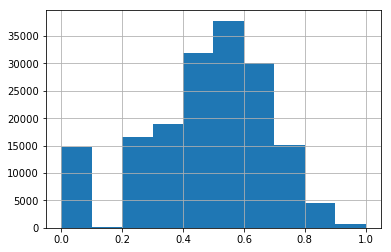

In [24]:
song_hotness_lyrics.hotness.hist()

Seems to look like a gaussian, except for these 0 values:

In [27]:
print("There are {} songs with hotness 0".format(song_hotness_lyrics[song_hotness_lyrics["hotness"] == 0].shape[0]))

There are 14756 songs with hotness 0


That makes almost 15000 songs for which we are somehow "unsure" about. Are those really songs with 0 popularity ?! Maybe they really didn't touch anyone or very few people. But let's look at the bright side: even if we cut them out in our analysis, we are still left with approximately 155000 songs for which we know the popularity value and the lyrics. But we still have to decide what we will do with these 15000 songs, will we keep them or exclude them ? Maybe we will keep them and treat them separately also. 

Anyway, Million Song and Echo Nest have our back covered: we can use another popularity measure which is the play count ! But this value is present in [another dataset](https://labrosa.ee.columbia.edu/millionsong/tasteprofile). If this doesn't work work we might also use the [Yahoo ratings dataset](https://labrosa.ee.columbia.edu/millionsong/pages/tasks-demos#yahoodata) but this one is for artist rating more than song rating so we should be careful if we decide to include it too. So let's proceed with Taste Profile !

# 8. Popularity of a song: the play counts
In this section we look at the number of times a song has been played (the play count) using the [The Echo Nest Taste Profile Dataset](https://labrosa.ee.columbia.edu/millionsong/tasteprofile) (if you were looking for a direct download link [here it is](http://labrosa.ee.columbia.edu/millionsong/sites/default/files/challenge/train_triplets.txt.zip))

In [45]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

%matplotlib inline

In [39]:
PLAY_COUNTS_FILE = "../datasets/train_triplets.txt"
SONGS_COUNTS_FILE = "../datasets/songs-counts.csv"

The *train_triplets.txt* file contains triplets of (User, Song, Play count) and it's almost 3GB large. It contains no header and is *Tab* separated.

In [40]:
play_counts = pd.read_table(PLAY_COUNTS_FILE, header=None, names=["users","songs","counts"])
play_counts.head(10)

,users,songs,counts
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1


In [41]:
play_counts.describe()

,counts
count,4.837359e+07
mean,2.866859e+00
std,6.437725e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,9.667000e+03


What we need is the mapping song -> play count. We'll produce a new file containing only this information

In [42]:
songs_counts = play_counts.groupby(by="songs").sum()
songs_counts.head()

,counts
songs,
SOAAADD12AB018A9DD,24
SOAAADE12A6D4F80CC,12
SOAAADF12A8C13DF62,9
SOAAADZ12A8C1334FB,12
SOAAAFI12A6D4F9C66,188


In [44]:
songs_counts.describe()

,counts
count,384546.000000
mean,360.633690
std,3256.809395
min,1.000000
25%,8.000000
50%,32.000000
75%,133.000000
max,726885.000000


We see that we have 384546 songs at disposal here. We also see that there is a huge gap between the minimal number of play counts (1) and the maximal (726885). This indicates simply that songs which are popular are really popular !

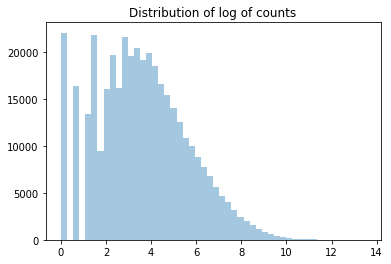

In [57]:
plt.title("Distribution of log of counts")
sns.distplot(songs_counts.apply(np.log), kde=False)

Now we just want to save everything so we don't lose it:

In [43]:
songs_counts.to_csv(SONGS_COUNTS_FILE)

## Song ID vs Track ID

Also, we notice that, for the Taste Profile dataset, we have the "song IDs" instead of the track IDs. But we also have this information for each track in our Million Song dataset (field 17):

In [17]:
f = h5py.File(os.path.join(base_dir_data, "A/A/A/TRAAAAK128F9318786.h5"))
list(f["metadata/songs"].attrs.items())[20]

('FIELD_17_NAME', b'song_id')

So let's simply create a function for getting the metadata we need. Here we can specify the indices of the attribute we need with the ```info``` attribute. For example, here we put ```info = [17]``` which means that we want the 17-th attribute which is the song ID (just after the 16-th which is the song hotness).

In [48]:
def get_msd_info(basedir, info=[], info_names=[], ext='.h5', subfolder="metadata/"):
    result = pd.DataFrame(columns=["track_id"] + info_names)
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root, '*'+ext))
        for f in files:
            h5_file = h5py.File(str(f))
            row = [f.split(os.path.sep)[-1].split(".")[0]] + [h5_file[subfolder + "songs"].value[0][i].decode("UTF-8") for i in info]
            result.loc[result.shape[0]] = row
    return result

In [49]:
song_ids_A = get_msd_info(os.path.join("..", "datasets", 'A'), info=[17], info_names=["song_id"])

In [52]:
song_ids_A.head()

,track_id,song_id
0,TRAAAAW128F429D538,SOMZWCG12A8C13C480
1,TRAAABD128F429CF47,SOCIWDW12A8C13D406
2,TRAAADZ128F9348C2E,SOXVLOJ12AB0189215
3,TRAAAEF128F4273421,SONHOTT12A8C13493C
4,TRAAAFD128F92F423A,SOFSOCN12A8C143F5D


In [51]:
song_ids_A_frame = song_ids_A.set_index("song_id")
song_ids_A_frame.columns = ["track_id"]
song_ids_A_frame.head()

,track_id
song_id,
SOMZWCG12A8C13C480,TRAAAAW128F429D538
SOCIWDW12A8C13D406,TRAAABD128F429CF47
SOXVLOJ12AB0189215,TRAAADZ128F9348C2E
SONHOTT12A8C13493C,TRAAAEF128F4273421
SOFSOCN12A8C143F5D,TRAAAFD128F92F423A


We run this code only for subfolder A for now. We will run it on the cluster for the entire dataset the same way we did for hotness when we will need it.

It would be good if we could also have the dates for our songs:

In [4]:
dates_A = get_msd_info(os.path.join("../datasets/", 'A'), info=[1], subfolder="musicbrainz/")

In [7]:
dates_A = dates_A.set_index("track_id")
dates_A.columns = ["date"]
dates_A.head()

,date
track_id,
TRARRQU128F427DAD3,0
TRARRAO128F145D072,1995
TRARRWA128F42A0195,2007
TRARRYB128F426BC39,0
TRARRNK12903D0C0DA,0


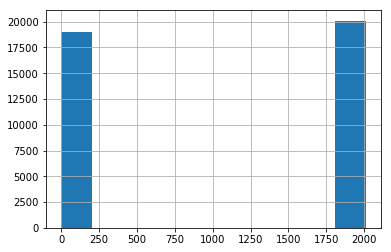

In [20]:
dates_A.date.hist(bins=10)

Ok so we have a problem here: almost half of the subset A doesn't contain the release date (= 0) so we will have to find a way to deal with that. Otherwise let's take a loser look at the "good" datapoints:

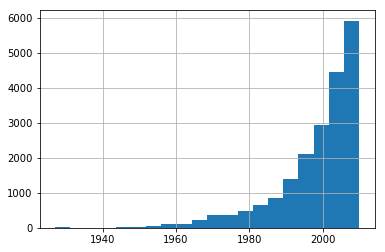

In [21]:
dates_A[dates_A.date != 0].date.hist(bins=20)

The distribution seems to be pretty nice and, of course, we have more and more songs as time advances to the 2000's, which is normal. So, to conclude with the date analysis, we will probably have less songs for the time trends part of our project but even then we should have enough songs to produce pretty accurate results (we still have to run the data retrieval scripts on the cluster the same way we did for hotness in order to figure out exactly how many songs will be usable). But if we take all the usable songs with respect to the lyrics (155000) and we remove half of them uniformly at random (since half of songs don't have a date) then we should be left with 75000 songs. And that is the worst case because we can somehow guess that, if we have the lyrics for a song, then the likelihood that we also have the release date for it is probably higher. Anyway, we have to do our analysis on the whole MSD dataset to be sure about that...

Just for information we have computed such a frame for subfolder A:

In [29]:
frame_hotness_date_A = pd.read_csv(os.path.join(r'../datasets/', 'test_A_hotness_date.csv'))
frame_hotness_date_A = frame_hotness_date_A[frame_hotness_date_A["date"] != 0]
frame_hotness_date_A.head()

,id,hotttnesss,date
0,TRAAAAV128F421A322,0.481694,2005
2,TRAAAFD128F92F423A,0.604501,2007
3,TRAAAHJ128F931194C,0.708009,2004
4,TRAAARJ128F9320760,0.265861,1984
5,TRAABEV12903CC53A4,0.502544,2000


In [30]:
frame_hotness_date_A.describe()

,hotttnesss,date
count,5115.000000,5115.000000
mean,0.511175,1999.194526
std,0.189331,9.160472
min,0.000000,1955.000000
25%,0.413740,1995.000000
50%,0.535512,2002.000000
75%,0.637892,2006.000000
max,1.000000,2010.000000


In [31]:
nb_date_hotness_usable_songs = frame_hotness_date_A.shape[0]
print("Out of the 39100 songs in subfolder A {} have a usable date and hotness with available lyrics".format(nb_date_hotness_usable_songs))
print("So our estimate for one million songs is {}".format(1000000 * (5115 / 39100)))

Out of the 39100 songs in subfolder A 5115 have a usable date and hotness with available lyrics
So our estimate for one million songs is 130818.41432225064


So if our estimates for subfolder A are correct for the entire dataset then we should have around 130000 usable songs for time trend analysis, which is more than enough for doing some interesting calculations !

<a id='milestone_3'></a>
# Milestone 3 : answering our questions

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# This variable should be set to false, unless you are running this part without the
# generated datasets
first_time = False

I'm having problems with the pattern

`frame["col"] = new_value`

It always throws warnings, according to SO, it seems to be a viable option to switch the warnings off.
https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

Remember, we have computed the song word count at three levels of "swear word categories":

In [4]:
offensiveness_rating = pd.read_pickle("../pickles/offensiveness_rating_structured")
offensiveness_rating.head()

('TRAAAAV128F421A322', 'non-discriminatory', 'mild', nan)      1
('TRAAAAV128F421A322', nan, nan, nan)                        102
('TRAAABD128F429CF47', nan, nan, nan)                        226
('TRAAAED128E0783FAB', nan, nan, nan)                        421
('TRAAAEF128F4273421', nan, nan, nan)                        139
Name: count, dtype: int64

Now, the problem is that we have tuples as index but we would like to have all these categories in different columns. So we do some processing to take care of that:

In [5]:
def process_tuple(t):
    
    def process_tuple_elem(elem):
        if elem == "nan":
            return np.nan
        else:
            return elem[1:-1]
    return list(map(process_tuple_elem, t[1:-1].replace(" ", "").split(",")))
index_offensiveness = list(map(process_tuple, offensiveness_rating.index.tolist()))

In [6]:
value_offensiveness = list(offensiveness_rating.values)

In [7]:
data_non_flat = list(zip(index_offensiveness, value_offensiveness))

In [8]:
columns = ["track_id", "category", "strength", "target", "value"]
track_off = pd.DataFrame.from_records([elem[0] + [elem[1]] for elem in data_non_flat], columns=columns)
track_off = track_off.set_index(["track_id", "category", "strength", "target"])
track_off.head()

value
track_id           category           strength target       
TRAAAAV128F421A322 non-discriminatory mild     NaN         1
                   NaN                NaN      NaN       102
TRAAABD128F429CF47 NaN                NaN      NaN       226
TRAAAED128E0783FAB NaN                NaN      NaN       421
TRAAAEF128F4273421 NaN                NaN      NaN       139

That's it, we have our multi-index structure. Now, we have the choice: absolute or relative count of swear words in a song ? This choice is rather difficult. But, in some way, even if a song is longer than another one, we can (for now) consider that simply having more swear words is equivalent to being more vulgar. So let's simply count the number of swear words per song:

In [9]:
%%time 
if first_time:
    track_offensiveness = track_off.groupby(by="track_id").apply(lambda frame: frame.reset_index().dropna(thresh = 3).value.sum())
    track_offensiveness = track_offensiveness.fillna(0)
    track_offensiveness.to_csv("../datasets/track_offensiveness.csv")
else:
    track_offensiveness = pd.read_csv("../datasets/track_offensiveness.csv", header=None)

CPU times: user 160 ms, sys: 8 ms, total: 168 ms
Wall time: 169 ms


And here is our frame relating a song with its offensiveness (so, for example, the song with track ID 'TRAAAAV128F421A322' contains one swear word)

In [10]:
track_offensiveness.columns=["track_id", "offensiveness"]
track_offensiveness.head()

,track_id,offensiveness
0,TRAAAAV128F421A322,1.0
1,TRAAABD128F429CF47,0.0
2,TRAAAED128E0783FAB,0.0
3,TRAAAEF128F4273421,0.0
4,TRAAAEW128F42930C0,0.0


We take only the columns we are interested in:

In [11]:
song_info = pd.read_csv("../datasets/total.csv")[["track_id", "genre", "song_hotness",
                                                            "song_id", "title", "year"]]
song_info.head()

,track_id,genre,song_hotness,song_id,title,year
0,TRBEEBA128F9354588,NaN,NaN,SOKZDUY12AC9E12A16,(Sweat_ Sweat),2007
1,TRBEEYF128EF34152F,NaN,NaN,SOEEDAK12A67AE2142,Heavenly (Instrumental Dub),0
2,TRBEEME128F42274E2,NaN,NaN,SOLVIJZ12A6D4FC406,In The Right Way,2000
3,TRBEENM12903CDA90A,NaN,0.51876,SOKLANA12A8C14016F,Hacha Y Machete,1976
4,TRBEETN128F4290E24,NaN,NaN,SOLODJD12A8C139CE3,Bus Stop,1968


### English songs
We now want to do our analysis for english songs only so we read the corresponding track IDs. The process of "detecting" which songs are in english is described in [this notebook](handling_languages.ipynb).

In [12]:
english_songs = pd.read_csv("../datasets/tracks_english.csv", header=-1)[1]
print("We have {} english songs.".format(english_songs.shape[0]))
english_songs = english_songs.to_frame()
english_songs.columns = ["track_id"]
english_songs.head()

We have 202115 english songs.


,track_id
0,TRAAAAV128F421A322
1,TRAAABD128F429CF47
2,TRAAAED128E0783FAB
3,TRAAAEF128F4273421
4,TRAAAEW128F42930C0


In [13]:
english_songs.columns

Index(['track_id'], dtype='object')

In [14]:
track_offensiveness.columns

Index(['track_id', 'offensiveness'], dtype='object')

In [15]:
english_track_offensiveness = english_songs.merge(track_offensiveness, on="track_id")
print("We have {} songs.".format(english_track_offensiveness.shape[0]))
english_track_offensiveness.columns = ["track_id", "abs_offensiveness"]
english_track_offensiveness.head()

We have 202115 songs.


,track_id,abs_offensiveness
0,TRAAAAV128F421A322,1.0
1,TRAAABD128F429CF47,0.0
2,TRAAAED128E0783FAB,0.0
3,TRAAAEF128F4273421,0.0
4,TRAAAEW128F42930C0,0.0


In [16]:
song_info_offensiveness = song_info.merge(english_track_offensiveness.reset_index(), on="track_id")
song_info_offensiveness = song_info_offensiveness.rename(columns={0: "abs_offensiveness"})
song_info_offensiveness.head()

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness
0,TRBEEGF128F42AB67E,NaN,0.000000,SOMYKOX12A8C13D59F,Collision Course,0,9341,0.0
1,TRBEEPA128F4291036,NaN,NaN,SOTOLDX12A58A79206,Fermented Offal Discharge,1995,9345,1.0
2,TRBEEEA128F92E7EED,NaN,NaN,SOGLPMS12D02193D69,Fake Messiah (Album Version),2009,9339,0.0
3,TRBEERY128F4231A2E,NaN,0.528782,SOVSBWN12A813557F9,Eyes Of A Stranger (Album Version),0,9346,0.0
4,TRBEEXV128F93116C9,NaN,0.227736,SOJHHMQ12AB017C6A6,Don't Ya Ever Leave Me (Live),0,9348,0.0


That's good, we have more than 200000 english songs with absolute offensiveness value. The two other values we will be the most focused on are the song hotness and the year. So we need to keep those where the year is not 0 and the song hotness is not nan. For now, let's proceed by keeping only datapoints with positive hotness value.

### Combine with play counts

In [17]:
songs_counts=pd.read_csv("../datasets/songs-counts.csv")
songs_counts.head()

,songs,counts
0,SOAAADD12AB018A9DD,24
1,SOAAADE12A6D4F80CC,12
2,SOAAADF12A8C13DF62,9
3,SOAAADZ12A8C1334FB,12
4,SOAAAFI12A6D4F9C66,188


In [18]:
songs_counts.columns=["song_id", "counts"]

Now we have all our songs information with the absolute offensiveness and the play counts in the `songs` dataframe:

In [19]:
songs = song_info_offensiveness.merge(songs_counts, on="song_id")
songs.head()

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness,counts
0,TRBEEPA128F4291036,NaN,NaN,SOTOLDX12A58A79206,Fermented Offal Discharge,1995,9345,1.0,227
1,TRBEERY128F4231A2E,NaN,0.528782,SOVSBWN12A813557F9,Eyes Of A Stranger (Album Version),0,9346,0.0,1168
2,TRBEEZO12903D05259,NaN,0.520345,SOUDWTU12AC37746F7,Spade and Parade,1994,9350,1.0,68
3,TRBEEEO128F146B9F1,NaN,NaN,SOPGDTB12A6D4F740A,Driving With The Brakes On,1995,9340,0.0,191
4,TRBEEYL128F1491A39,NaN,NaN,SOLTMAH12A6D4FA0B3,Making Waves (2003 Digital Remaster),2002,9349,0.0,13


In [27]:
songs.to_csv("../datasets/songs.csv")

## Looking at simple correlations between offensiveness, hotness, counts and year

In [28]:
# select the values we want to have
off_hot_year = songs[["song_hotness", "year", "abs_offensiveness", "counts"]]

# for this superficial analysis, we clean the data aggressively
off_hot_year = off_hot_year.query("year > 0")
off_hot_year = off_hot_year.query("counts > 1")

In [29]:
off_hot_year.corr()

,song_hotness,year,abs_offensiveness,counts
song_hotness,1.000000,0.186625,-0.006918,0.129653
year,0.186625,1.000000,0.016476,0.020274
abs_offensiveness,-0.006918,0.016476,1.000000,0.004138
counts,0.129653,0.020274,0.004138,1.000000


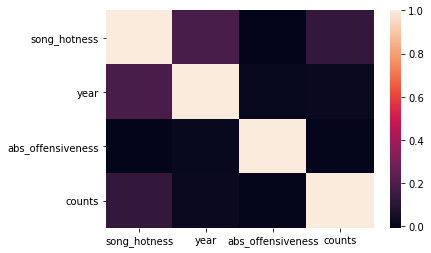

In [30]:
corr = off_hot_year.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Looking at correlations: Discussion
We don't see any correlation. This was a very superficial analysis. In a next step we will try to go into more detail

## Applying filtering and smoothing
Correlation is a very simple tool which only looks for linear dependancies. For the raw data, we don't see any correlations. But this doesn't mean that there is no connection. A simple explanation would be that we need to apply more data cleaning. This is what we will do now:
 - apply a variety of filtering operations to find correlations in subsets of the data.
 - try to smooth the data


In [31]:
# smoothing the counts by using their log
offensiveness_counts = songs[["song_hotness", "year", "abs_offensiveness", "counts"]]

offensiveness_counts_log = offensiveness_counts.copy()
offensiveness_counts_log["counts"] = offensiveness_counts_log["counts"].apply(lambda x : np.log(x))
offensiveness_counts_log.corr()

,song_hotness,year,abs_offensiveness,counts
song_hotness,1.000000,0.217558,-0.012522,0.508213
year,0.217558,1.000000,-0.039431,0.112978
abs_offensiveness,-0.012522,-0.039431,1.000000,0.013263
counts,0.508213,0.112978,0.013263,1.000000


In [32]:
# looking only at songs that have been played often
offensiveness_counts_popular = offensiveness_counts_log.query("counts> 3")
offensiveness_counts_popular.corr()

,song_hotness,year,abs_offensiveness,counts
song_hotness,1.000000,0.178415,-0.019310,0.433320
year,0.178415,1.000000,-0.037461,0.051465
abs_offensiveness,-0.019310,-0.037461,1.000000,0.015510
counts,0.433320,0.051465,0.015510,1.000000


In [33]:
# looking only at recent songs
offensiveness_counts_recent = songs.query("year > 1990")[["abs_offensiveness", "counts"]]
offensiveness_counts_recent.corr()

,abs_offensiveness,counts
abs_offensiveness,1.000000,0.005394
counts,0.005394,1.000000


In [34]:
# looking only at very recent songs
offensiveness_counts_very_recent = songs.query("year > 2000")[["abs_offensiveness", "counts"]]
offensiveness_counts_very_recent.corr()

,abs_offensiveness,counts
abs_offensiveness,1.000000,0.007334
counts,0.007334,1.000000


### Filtering and smoothing: Discussion

This doesn't give us any information either. The evaluations I have included above are just a selection of tests. I have tried a variety of filters and smoothings.

Unfortunately, I couldn't find any significant result. This doesn't mean that there is no dependence between the data points, but it does seem as if there is no linear dependence.

Next, we need to take a step back. Correlation uses a linear model to explain the data, this is not powerful enough. Before we try fitting a more complex model, we should investigate the data and make a principled decision.


## Correlations over time

In this section we inspect the data in order to find out whether there exists a correlation over time for our data. Here we give the results but if you want to have all the details you can take a look at [this](main_nb.ipynb) notebook.

In [21]:
def correlate_for_swear_attributes(track_off, category="none", strength="none", target="none", plot_now=True):
    """
    This method plots the date correlations for the specified parameters. If the 3 are "none"
    then the correlations will be computed based on all swear words.
    """
    def get_off_count_based_on(track_off, category, strength, target):
        track_off_nidx = track_off.reset_index().fillna("none")
        return track_off_nidx.query("(category == @category and strength == @strength and target == @target) or\
                                (category == 'none' and strength == 'none' and target == 'none')").replace("none", np.nan)
    def get_off_based_on(track_off, category, strength, target):
        count_off = get_off_count_based_on(track_off, category, strength, target)
        count_off_non_na = count_off[count_off.duplicated("track_id", keep=False)].dropna(thresh=3)
        count_off_non_na.loc[:, "offensiveness"] = count_off_non_na["value"]
        count_off_na = count_off.drop_duplicates("track_id",keep=False)
        count_off_na.insert(0, "offensiveness", 0)
        return pd.concat([count_off_non_na, count_off_na])[["track_id", "offensiveness"]]
    
    all_swear_words = category == "none" and strength == "none" and target == "none"
    
    english_songs = pd.read_csv("../datasets/tracks_english.csv", header=-1)[1].to_frame()
    english_songs.columns = ["track_id"]
    song_info = pd.read_csv("../datasets/total.csv")[["track_id", "genre", "song_hotness",
                                                            "song_id", "title", "year"]]
    label = "all"
    if all_swear_words:
        # We want all categories/strength/targets:
        print("Correlations for all swear words:")
        if first_time:
            track_off_group = track_off.groupby(by="track_id").apply(lambda frame: frame.reset_index().dropna(thresh = 3).value.sum())
            track_off_group = track_off_group.fillna()
        else:
            track_off_group = pd.read_csv("../datasets/track_offensiveness.csv", header=-1)
            track_off_group.columns = ["track_id", "offensiveness"]
    else:
        print("Correlations for category = {}, strength = {} and target = {}".format(category, strength, target))
        label = "{}, {}, {}".format(category, strength, target)
        track_off_group = get_off_based_on(track_off, category, strength, target)
        
    english_track_offensiveness = english_songs.merge(track_off_group.reset_index(), on="track_id")
    song_info_offensiveness = song_info.merge(english_track_offensiveness, on="track_id")
    song_info_offensiveness = song_info_offensiveness[["track_id", "song_hotness", "year", "offensiveness"]]
    song_info_offensiveness = song_info_offensiveness.dropna().query("year > 0 and song_hotness > 0")
    year_correlation = song_info_offensiveness.groupby(by="year").apply(lambda frame: frame.song_hotness.corr(frame.offensiveness))
    year_correlation = year_correlation.dropna()
    year_correlation = year_correlation.to_frame().reset_index()
    year_correlation.columns = ["year", "correlation"]
    
    plt.plot(year_correlation.year.tolist(), year_correlation.correlation.tolist(), label = label)
    if plot_now:
        plt.show()

Here are the general correlations for all swear words:

Correlations for all swear words:


/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/numpy/lib/function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


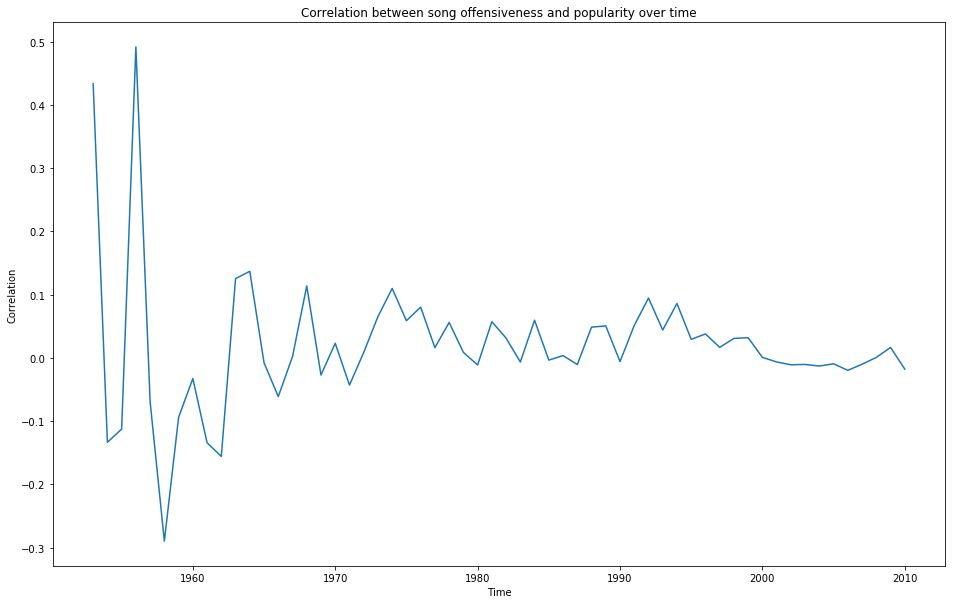

In [23]:
plt.figure(figsize=(16, 10))
plt.title("Correlation between song offensiveness and popularity over time")
plt.ylabel("Correlation")
plt.xlabel("Time")
correlate_for_swear_attributes(track_off, "none", "none", "none", False)
plt.show()

We see that the correlation tends to 0 as time advances (we should not care too much about the spikes at the beginning: there are two few songs for those time periods so we cannot take those correlations seriously - only one offensive and popular/unpopular song can make the correlation jump very high)

Since we do not get meaningful results for all swear words let's take the groups of swear words one-by-one and see if we find something:

Correlations for category = non-discriminatory, strength = mild and target = none


/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/numpy/lib/function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


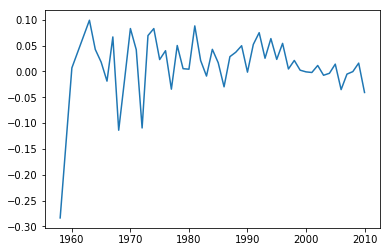

Correlations for all swear words:


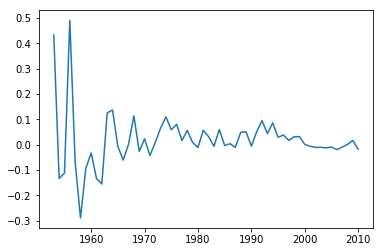

Correlations for category = discriminatory, strength = mild and target = mentalorphysicalability


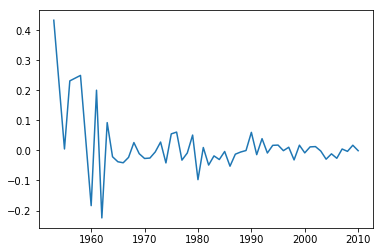

Correlations for category = discriminatory, strength = strongest and target = race


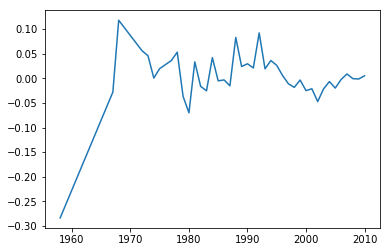

Correlations for category = non-discriminatory, strength = medium and target = none


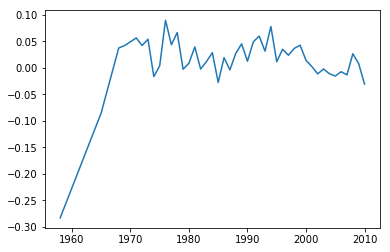

Correlations for category = non-discriminatory, strength = strongest and target = none


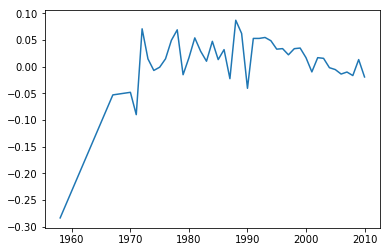

Correlations for category = discriminatory, strength = medium and target = mentalorphysicalability


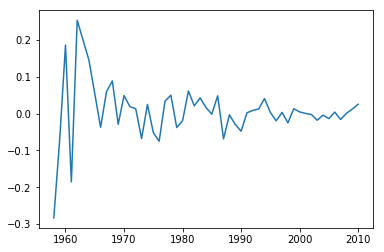

Correlations for category = discriminatory, strength = mild and target = sexuality


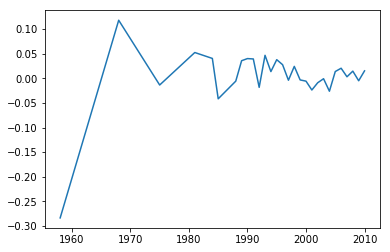

Correlations for category = discriminatory, strength = strongest and target = mentalorphysicalability


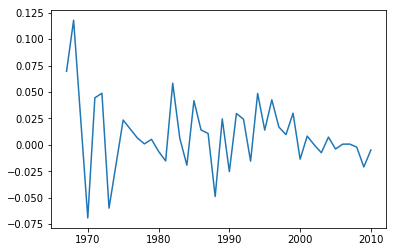

Correlations for category = non-discriminatory, strength = strong and target = none


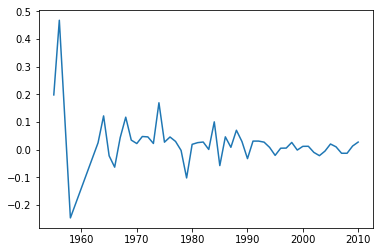

Correlations for category = discriminatory, strength = strong and target = sexuality


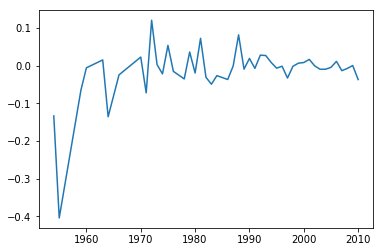

Correlations for category = discriminatory, strength = medium and target = race


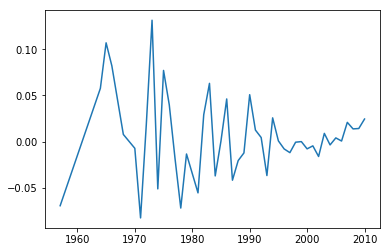

In [22]:
all_combinations = track_off.reset_index()[["category", "strength", "target"]].drop_duplicates()
all_combinations = all_combinations.fillna("none")
for i in range(all_combinations.shape[0]):
    row = all_combinations.iloc[i]
    correlate_for_swear_attributes(track_off, row["category"], row["strength"], row["target"])

Again, the correlation simply seems to tend to 0 as in the first graph. Let's see how those graphs look like if we put them on one same plot:

(8, 3)
Correlations for category = discriminatory, strength = medium and target = race


/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/numpy/lib/function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/ahmed/python_libs/anaconda3/envs/ada/lib/python3.5/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


Correlations for category = discriminatory, strength = strongest and target = mentalorphysicalability
Correlations for category = discriminatory, strength = mild and target = mentalorphysicalability
Correlations for category = discriminatory, strength = strongest and target = race
Correlations for category = discriminatory, strength = medium and target = mentalorphysicalability
Correlations for category = discriminatory, strength = mild and target = sexuality
Correlations for category = non-discriminatory, strength = medium and target = none
Correlations for category = non-discriminatory, strength = mild and target = none


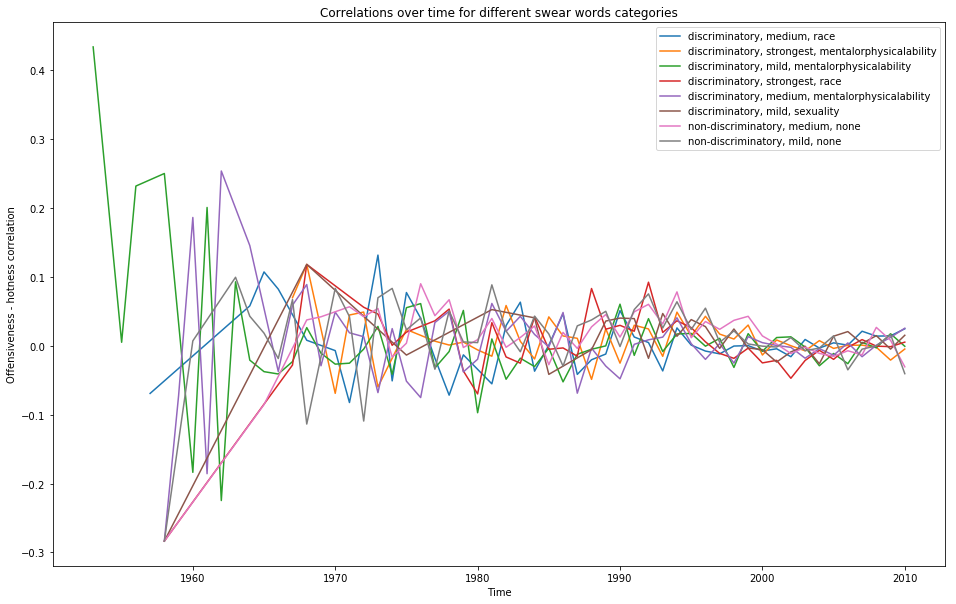

In [24]:
combinations_to_show = all_combinations.sample(8)
plt.figure(figsize=(16, 10))
for i in range(combinations_to_show.shape[0]):
    row = combinations_to_show.iloc[i]
    correlate_for_swear_attributes(track_off, row["category"], row["strength"], row["target"], plot_now=False)
plt.title("Correlations over time for different swear words categories")
plt.xlabel("Time")
plt.ylabel("Offensiveness - hotness correlation")
plt.legend()
plt.show()

We took only 8 out of the 12 possible combinations (just to respect the "not many color" rule) but we tried this multiple times and what matters is that see that all the plots basically tend to zero as soon as we have enough data. So there is no correlation over time !

## Looking at the data directly

Sometimes, scatter plots can be an effective tool to show structure in the data. These plots have to be used with caution: The scatter plots I'm using are not heatmaps, they give no intuition for the density of the data.

The results could be misleading, they are only meant to provide idea for the models to fit to the data.

## Scatter years and offensiveness

This seems to show that songs become more offensive over time.

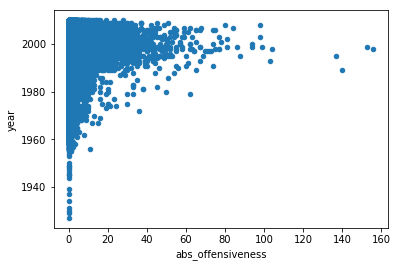

In [35]:
songs[songs["year"]>0].plot.scatter("abs_offensiveness", "year")

## Scatter offensiveness and play counts

This seems to show that play counts actually decrease with offensiveness.

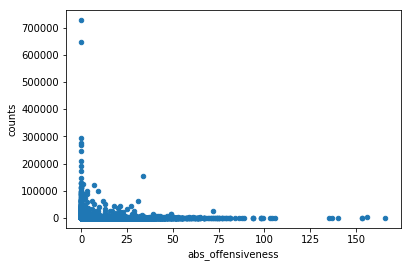

In [36]:
songs.plot.scatter("abs_offensiveness", "counts")

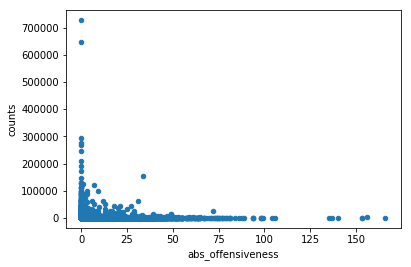

In [37]:
songs.query("counts > 1").plot.scatter("abs_offensiveness", "counts")

## Scatter offensiveness and hotness

We have to filter the hotness a lot.

This is actually the most interesting plot, I think.
It seems that "average" songs are the most offensive.

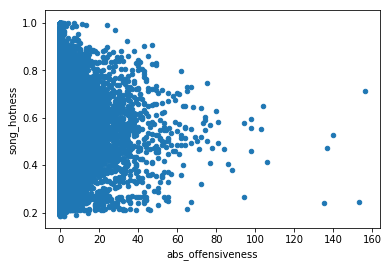

In [38]:
songs[["song_hotness", "abs_offensiveness"]]\
    .dropna()\
    .query("song_hotness > 0.1")\
    .plot.scatter("abs_offensiveness", "song_hotness")

## Scatter plots: Intermediate Discussion

There seems to be some structure in the data.

Intuitively, I think the problem is that these trends are driven by a small subset of data points.
The outliers have some structure, the mass in center is useless.

Maybe we should just look at the development of offensive songs. I've filtered out songs of low offensiveness and am repeating the plots from above. The result is the same.


In [42]:
# for the songs that are offensive, what values do we see
songs.query("abs_offensiveness >= 1").describe()

,genre,song_hotness,year,index,abs_offensiveness,counts
count,0.0,22544.000000,26207.000000,26207.000000,26207.000000,26207.000000
mean,NaN,0.542212,1602.315832,101354.288434,4.601175,539.737856
std,NaN,0.174127,798.014516,58148.651360,8.222534,2884.665691
min,NaN,0.000000,0.000000,0.000000,1.000000,1.000000
25%,NaN,0.458675,1985.000000,50938.000000,1.000000,16.000000
50%,NaN,0.563359,1999.000000,102256.000000,2.000000,63.000000
75%,NaN,0.656220,2005.000000,151720.500000,4.000000,278.000000
max,NaN,1.000000,2010.000000,202112.000000,166.000000,155717.000000


In [56]:
# so 50% of the offensive songs actually contain only <= 2 offensive words.
# we might want to exclude that
filtered_songs = songs.query("abs_offensiveness >= 2")

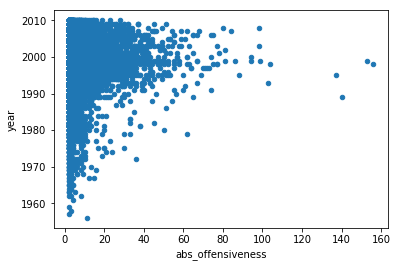

In [57]:
filtered_songs.query("year > 0").plot.scatter("abs_offensiveness", "year")

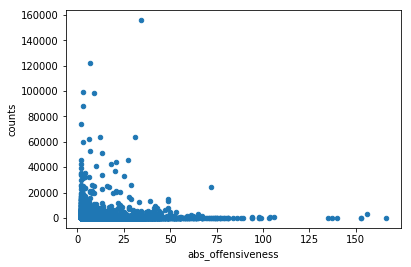

In [58]:
filtered_songs.plot.scatter("abs_offensiveness", "counts")

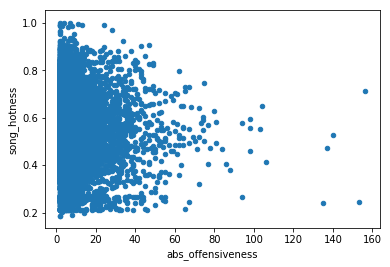

In [59]:
filtered_songs[["song_hotness", "abs_offensiveness"]]\
    .dropna()\
    .query("song_hotness > 0.1")\
    .plot.scatter("abs_offensiveness", "song_hotness")

# Discussion

The scatter plots from above give two insights:
 - The number of offensive songs seems to increase over time
 - Songs of average hotness are more offensive than songs of high or low hotness
 
As said above: scatterplots are not a good tool to get solid results. This is just an intuition and needs to be verified.

We will now construct metrics that we can plot over time.

In [60]:
# playcounts of offensive vs non-offensive songs
songs_binary = songs.copy()
songs_binary["offensive"] = songs_binary["abs_offensiveness"].apply(lambda x : x>0)
songs_binary.head()

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness,counts,offensive
0,TRBEEPA128F4291036,NaN,NaN,SOTOLDX12A58A79206,Fermented Offal Discharge,1995,9345,1.0,227,True
1,TRBEERY128F4231A2E,NaN,0.528782,SOVSBWN12A813557F9,Eyes Of A Stranger (Album Version),0,9346,0.0,1168,False
2,TRBEEZO12903D05259,NaN,0.520345,SOUDWTU12AC37746F7,Spade and Parade,1994,9350,1.0,68,True
3,TRBEEEO128F146B9F1,NaN,NaN,SOPGDTB12A6D4F740A,Driving With The Brakes On,1995,9340,0.0,191,False
4,TRBEEYL128F1491A39,NaN,NaN,SOLTMAH12A6D4FA0B3,Making Waves (2003 Digital Remaster),2002,9349,0.0,13,False


In [61]:
songs_binary = songs_binary[["year", "counts", "offensive"]]

In [62]:
songs.query("year >= 2000 and abs_offensiveness >= 1").shape

(12865, 9)

In [63]:
# the first occurence of an offensive song is
first_year = songs_binary.query("offensive == True and year > 0")["year"].min()
print("first occurence of an offensive song (in our data): "+str(first_year))

# creating query strings
offensive_query = "year > {0} and offensive == True".format(first_year)
not_off_query = "year > {0} and offensive == False".format(first_year)

# getting play counts
of_counts = songs_binary.query(offensive_query).groupby("year").agg("sum")["counts"]
no_counts = songs_binary.query(not_off_query).groupby("year").agg("sum")["counts"]

# calculating ratio
ratio = of_counts / (of_counts + no_counts)
ratio.head()

first occurence of an offensive song (in our data): 1955


year
1956    0.359954
1957    0.445140
1958    0.052062
1959    0.133210
1960    0.015698
Name: counts, dtype: float64

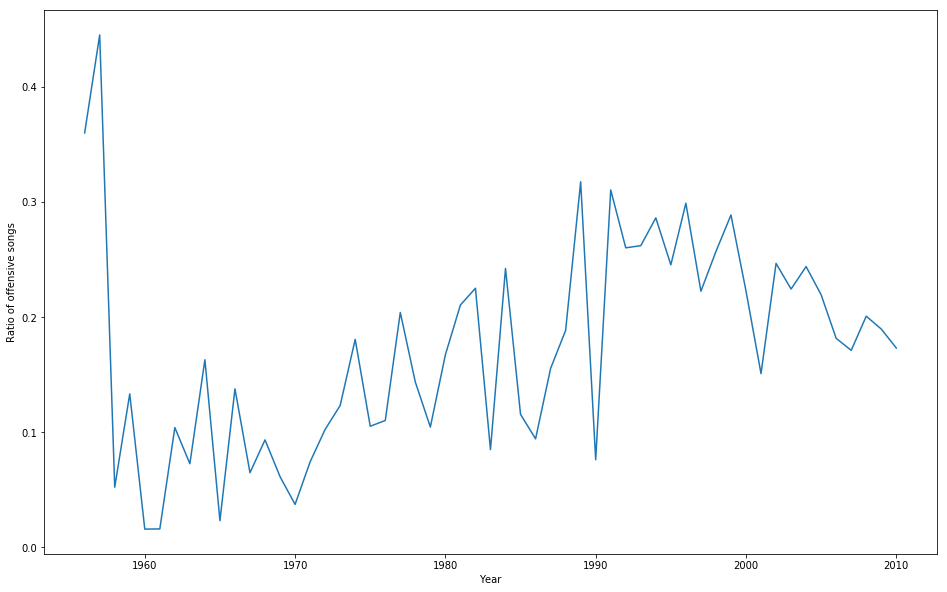

In [75]:
plt.figure(figsize=(16, 10))
plt.xlabel("Year")
plt.ylabel("Ratio of offensive songs")
plt.plot(ratio)
plt.show()

Still not saying something useful. Let's try another method: we will simply count the total number of swear words per year.

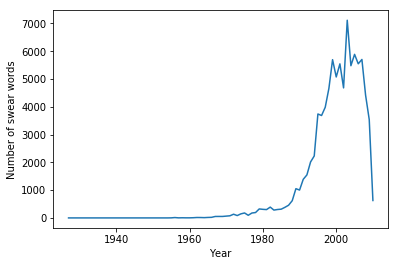

In [78]:
to_plot_total_off_vs_year = songs[["year", "abs_offensiveness"]].query("year > 0").groupby(by="year")
plt.figure()
plt.xlabel("Year")
plt.ylabel("Number of swear words")
plt.plot(to_plot_total_off_vs_year.sum())
plt.show()

We see that the total number of swear words goes up as year increases but this is normal because more songs implies more words. But let's see what we get if we divide that number by the number of songs (which would be the average number of swear words per song)

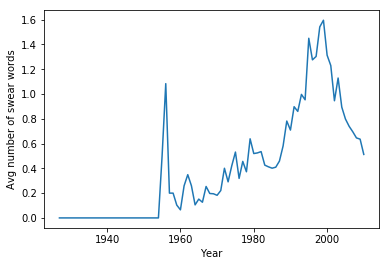

In [79]:
year_avg_off = to_plot_total_off_vs_year.apply(lambda frame: frame["abs_offensiveness"].sum() / frame.shape[0])
plt.figure()
plt.xlabel("Year")
plt.ylabel("Avg number of swear words")
plt.plot(year_avg_off)

Ok so we start seeing something interesting here: the average number of swear words per song is the highest somewhere around the year 2000 ! The year 1956 seems strangely more offensive than the others. Let's take a closer look:

In [25]:
songs.query("year==1956")

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness,counts
334,TRBMFFE12903CD8DBB,NaN,0.565451,SOVAJRE12AAF3B5D75,All Around the World,1956,11709,0.0,43
7202,TRKTSXR128F92D450C,NaN,0.527703,SORRERJ12A8C1423B4,Little Darlin',1956,84075,0.0,10
40638,TRUGFZM12903CC04E3,NaN,NaN,SOEWGGU12A8C133950,Love Me,1956,157794,0.0,1590
54930,TRCTNHQ128F92FA33F,NaN,0.651224,SOXQVNW12AAF3B2DBC,Need Your Love So Bad,1956,21630,0.0,180
57321,TRZMZTY128F1499425,NaN,NaN,SOIHGSM12A6D4FA0A6,Tenderly,1956,198369,0.0,264
70122,TREFXXT128F92F0CD5,NaN,0.616153,SOJFEXC12A8C142F91,Who Needs You,1956,33320,0.0,23
70891,TRESXGW128F426425A,NaN,NaN,SOVZKUJ12A58A7DAB7,Down Home Special,1956,37103,1.0,14
73127,TRXZLKU128F1462813,NaN,0.328609,SOSXZVJ12A6D4F6CB4,Oh_ Marie (2002 Digital Remaster),1956,186537,0.0,48
84223,TRQKNVC12903CB0448,NaN,0.618166,SODSPJZ12A8AE47A81,Bad Luck,1956,128172,1.0,249
87420,TRWXAZN128F426D7B5,NaN,NaN,SOFGKOE12A58A7DB22,Honey Chile,1956,178189,0.0,41


We see the song "Smokestack Lightning" here which seems to have 11 offensive words. Here are the lyrics:

Ah oh, smokestack lightnin'
Shinin', just like gold
Why don't ya hear me cryin'?
Whoo hoo
Whoo hoo
Whoo
Whoa oh, tell me, baby
What's the, matter with you?
Why don't ya hear me cryin'?
Whoo hoo
Whoo hoo
Whoo
Whoa oh, tell me, baby
Where did ya, stay last night?
A-why don't ya hear me cryin'?
Whoo hoo
Whoo hoo
Whoo
Whoa-oh, stop your train
Let her, go for a ride
Why don't ya hear me cryin'?
Whoo hoo
Whoo hoo
Whoo
Whoa-oh, fare ya well
Never see, a you no more
A-why don't ya hear me cryin'?
Whoo hoo
Whoo hoo
Whoo
Whoa-oh, who been here baby since,
I-I been gone, a little, bitty boy
Girl, be on
Whoo hoo
Whoo hoo
Whoo

There are absolutely no swear words here but, taking a closer look at our MusixMatch dataset we see that the word "hoo" was inserted as "ho" and it appears 11 times in MusixMatch. This is a problem but it is due to the dataset and we can't do much about it  (apart from trying to do some intense nlp which won't work anyway). But anyway, this is not a recurrent problem so we don't need to do worry too much about this. The only annoying thing is that, because of this, and because of the fact that there are only 12 songs for 1956, we get that the average number of swear words is 13 / 12 = 1.08. Fortunately, the number of songs becomes bigger and bigger over time so this problem becomes negligeable.

Let's get back to our offensiveness per year plots. Last method showed something like an increase of the average number of swear words over time and a decrease somewhere after the year 2000. But let's come back to our idea of ratio between the number of offensive vs non offensive songs. Maybe taking 1 as a threshold is not a good idea. Actually it is rather subjective at what swear words count someone will consider a song as offensive. So let's try to redo our ratio method but including thresholds:

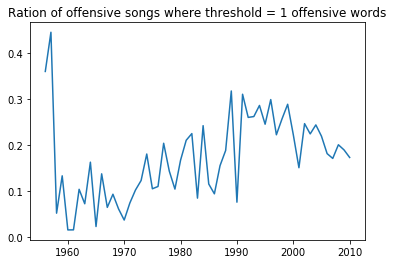

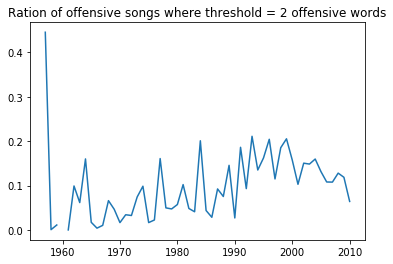

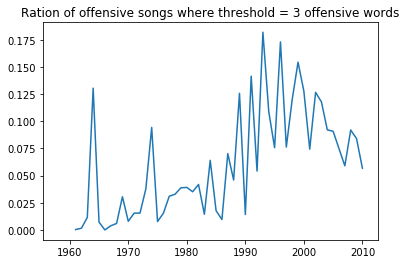

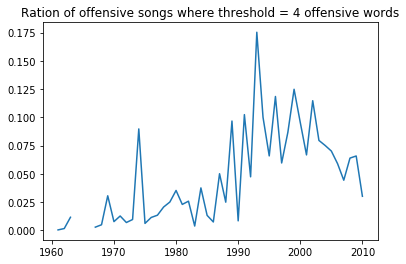

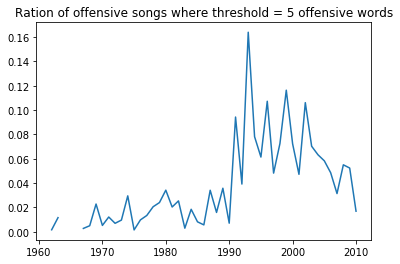

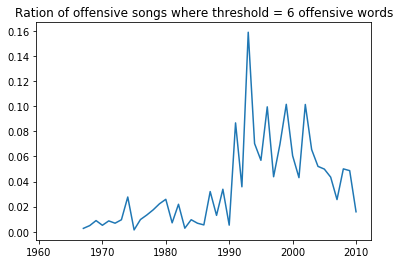

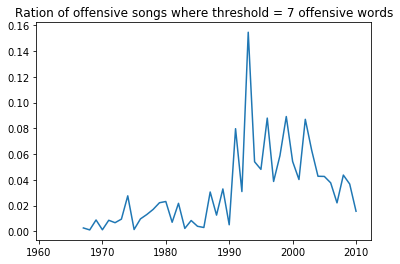

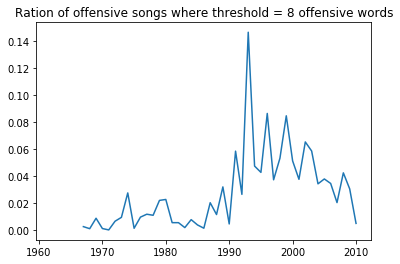

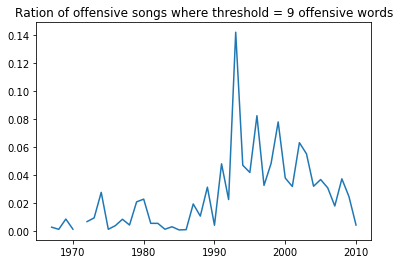

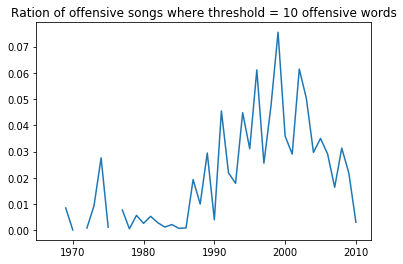

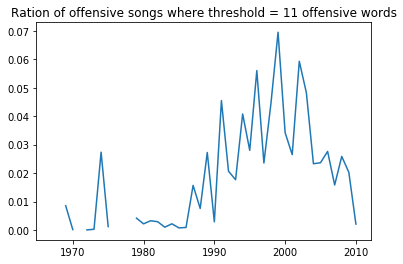

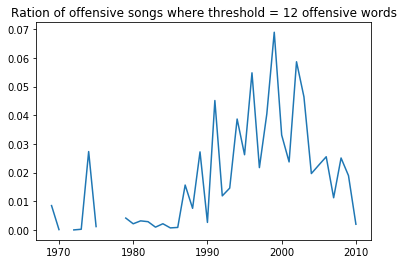

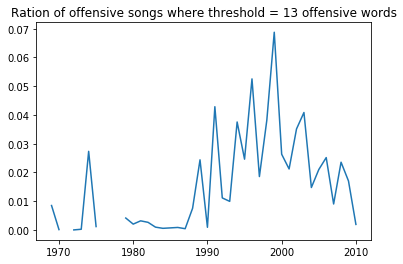

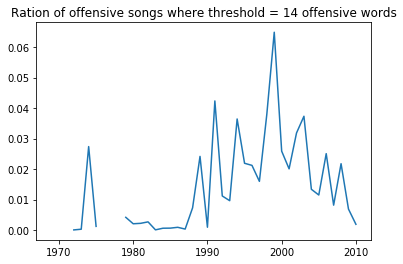

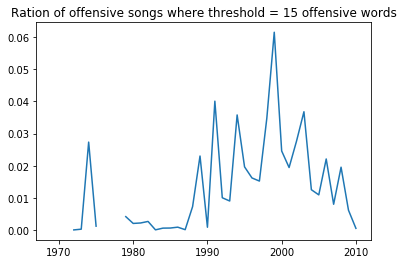

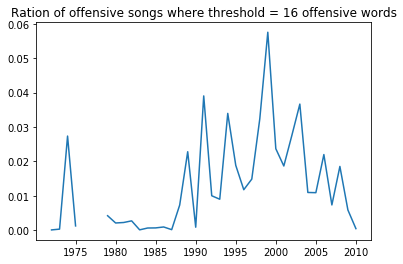

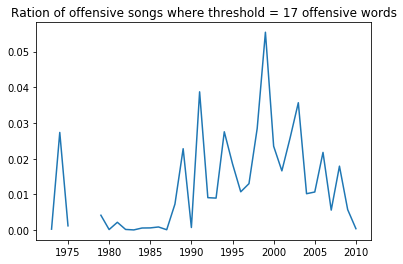

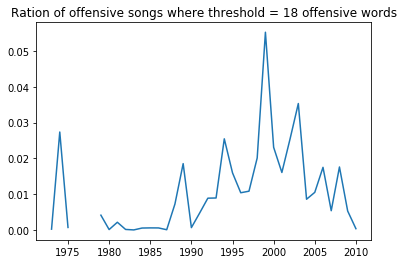

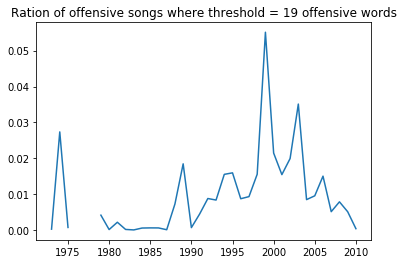

In [67]:
def ratio_offensiveness_year(threshold=1, show_plot=True):
    songs_binary = songs.copy()
    songs_binary["offensive"] = songs_binary["abs_offensiveness"].apply(lambda x : x>=threshold)

    songs_binary = songs_binary[["year", "counts", "offensive"]]
    first_year = songs_binary.query("offensive == True and year > 0")["year"].min()

    offensive_query = "year > {0} and offensive == True".format(first_year)
    not_off_query = "year > {0} and offensive == False".format(first_year)

    of_counts = songs_binary.query(offensive_query).groupby("year").agg("sum")["counts"]
    no_counts = songs_binary.query(not_off_query).groupby("year").agg("sum")["counts"]

    ratio = of_counts / (of_counts + no_counts)
    if show_plot:
        plt.figure()
        plt.title("Ration of offensive songs where threshold = {} offensive words".format(threshold))
        plt.plot(ratio)
        plt.show()
    else:
        plt.plot(ratio, label="threshold={}".format(threshold))

for i in range(1, 20):
    ratio_offensiveness_year(i)

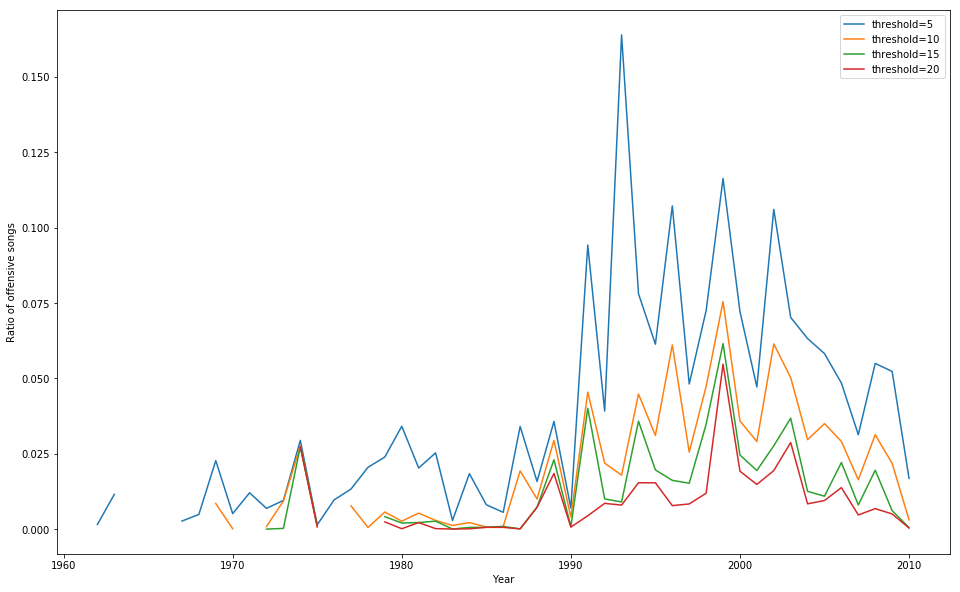

In [73]:
plt.figure(figsize=(16, 10))
plt.xlabel("Year")
plt.ylabel("Ratio of offensive songs")
for i in [5, 10, 15, 20]:
    ratio_offensiveness_year(i, False)
plt.legend()
plt.show()

So, as we increase the threshold, we get approximately to the same idea we had with the average number of swear words per song: the most offensive songs are located somewhere in the 1990 - 2000 decade and the trend is kept alive after that (with less intensity). Let's take a closer look at the most offensive songs:

In [92]:
most_offensive_songs = songs.sort_values("abs_offensiveness", ascending=False)[["title", "year", "abs_offensiveness", "song_hotness", "counts"]].head(12)
most_offensive_songs

,title,year,abs_offensiveness,song_hotness,counts
366,Don't Gimme No H.A.N./?,0,166.0,NaN,38
48862,Gangster Tripping,1998,156.0,0.711211,3326
35579,Down For My N's,0,153.0,0.246865,65
16525,Bitch Niggas,1999,153.0,NaN,58
9374,Roll Call,1989,140.0,0.528782,138
111983,Can't Tell Me Shit,1995,137.0,0.471971,26
20864,Booty Man (Remix),0,135.0,0.239629,135
117722,Stop Fuckin Wit Me,0,106.0,0.415050,443
55122,Acid 8000,1998,104.0,0.648113,424
54597,Lose A Hoe_ Gain A Hoe,1993,103.0,0.552007,1


In [93]:
with open('report/tables/most_offensive_songs.tex','w') as tf:
    tf.write(most_offensive_songs.to_latex(index=False))


This confirms our intuition. If we look at the top songs the majority of them (at least those where we have the year) seem to belong somewhere in the decade 1990 - 2000 (or around that decade - "Roll Call" is in 1989. This is not really a surprise since street rap music was on the rise back then. Rappers were even involved in clan shootings and they were writing their songs in a pretty dangerous environment (Tupac, one of the most famous rappers, was killed in a shooting in 1996 for example).

If we look at the lyrics of those songs we see that they are almost hilarious: maybe one word out of two is a swear word. For example, here is the chorus of the song "Bitch Niggaz" from Snoop Dogg and Dr. Dre:

Yeah
Bitch niggas (bitch niggas)
Bitch niggas (bitch niggas)
Bitch-ass niggas (beotch)
Bitch niggas (bitch niggas)
Yeah I'm talkin' about you (beotch)
Bitch niggas
And you too (beotch)

Basically, the rapper is simply repeating the same words "Bitch niggas" multiple times. We don't have time to show all the lyrics here but you can very easily find them on Google.

## Machine learning

None of the approaches above seem to reveal any data.

We will now try to apply a more powerful method. Instead of linear regression (correlation), or hand-crafted features, we use a multilayer perceptron to search for structure with a machine learning approach

### Step 1: convert dataframe to numpy array

We chose keras for the machine learning, it works on numpy arrays.
We also apply smoothing to the data

In [20]:
data_frame = songs.query("year>0").query("counts > 1").query("song_hotness<=1") [["year", "counts", "abs_offensiveness"]]
data_frame.head()

,year,counts,abs_offensiveness
2,1994,68,1.0
6,1992,316,0.0
7,2001,787,0.0
8,2003,1017,0.0
9,1995,79,0.0


In [21]:
# smoothing the data
data_frame["abs_offensiveness"]= data_frame["abs_offensiveness"].apply(lambda x: np.log(x) if x > 0 else x)
data_frame["counts"]= data_frame["counts"].apply(lambda x: np.log(x) if x > 0 else x)

In [22]:
data_frame.describe()

,year,counts,abs_offensiveness
count,86194.000000,86194.000000,86194.000000
mean,1999.662401,4.412470,0.166196
std,9.101687,1.913043,0.547155
min,1927.000000,0.693147,0.000000
25%,1996.000000,2.995732,0.000000
50%,2003.000000,4.317488,0.000000
75%,2006.000000,5.733341,0.000000
max,2010.000000,13.496524,5.049856


In [23]:
data = data_frame.values
data.shape

(86194, 3)

In [24]:
np.random.shuffle(data)

### Splitting into train, val, test

In [25]:
num_samples = data.shape[0]
X = data.copy()[:, :2].astype(np.float32)
y = data.copy()[:, 2].astype(np.float32)

In [26]:
X -= X.min(axis=0)
y -= y.min()

In [27]:
X /= X.max(axis=0)
y /= y.max()

In [28]:
train_split = int(num_samples*0.6)
test_split =  int(train_split + num_samples * 0.2)

X_train = X[:train_split]
y_train = y[:train_split]

X_test = X[train_split : test_split]
y_test = y[train_split : test_split]

X_val = X[test_split : ]
y_val = y[test_split : ]

### Setup and training of the model

In [30]:
import keras

from keras.models import Sequential
from keras.layers import Input, Dense, Activation

Using TensorFlow backend.


In [31]:
model = Sequential()
model.add(Activation(input_shape=(2, ), activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="mean_squared_error", optimizer="adam")

In [32]:
# the training is very fast
# this is not surprising, we only have 80000 data points and they are only 2 values, each
history = model.fit(X_train, y_train, verbose=2, epochs = 5)

Epoch 1/5
 - 2s - loss: 0.0213
Epoch 2/5
 - 2s - loss: 0.0119
Epoch 3/5
 - 2s - loss: 0.0119
Epoch 4/5
 - 1s - loss: 0.0119
Epoch 5/5
 - 2s - loss: 0.0119


In [33]:
# checking scores on test set,
# we get similar results, so there doesn't seem to be any overfitting
model.evaluate(X_test, y_test)

17238/17238 [==============================] - 0s 20us/step


0.012053877979254194

### Let's feed the model with some sample data

We want to see how offensiveness evolves over time.
We have seen above that popularity seems to have little influence on it.

So we plot a series of curves. They are the predicted offensiveness of a song with given popularity, over time.

In [429]:
predictions = []

for i in range(10):
    feed = np.zeros((50, 2))
    feed[:, 0] = np.linspace(0, 1, 50)
    popularity = i/10
    feed[:, 1] = popularity

    predictions.append((model.predict(feed), popularity))

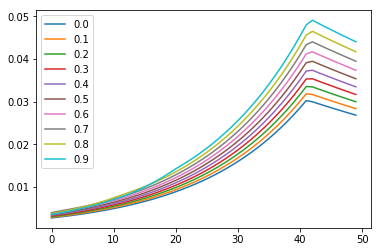

In [433]:
plt.figure()

for prediction, popularity in predictions:
    plt.plot(prediction, label=popularity)
    
plt.legend()
plt.show()